In [1]:
import scanpy as sc
import anndata
import os
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import umap
import seaborn as sns

import gseapy as gp


In [2]:
print("Scanpy version " + sc.__version__)
print("UMAP version " + umap.__version__)
print("Pandas version " +pd.__version__)
print("Numpy version "+np.__version__)

Scanpy version 1.7.2
UMAP version 0.5.1
Pandas version 1.1.5
Numpy version 1.19.2


In [3]:
plt.rcParams["figure.figsize"]=(6,6)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
t_adata_nodub=sc.read_h5ad("analysis_objects/nkt_nodoublets.h5ad")

In [8]:
sc.tl.rank_genes_groups(t_adata_nodub,groupby="NK/T Subclusters",pts=True)

In [9]:
def rename_genes_R_messed_up(des_res, t_adata_nodub):
    locs_reversed ={}
    for j,i in fmp.LOCs.items():
        i = i.replace("*",".")
        i=i.replace("-",".")
        i= i.replace(" ",".")
        i = i+"."
        locs_reversed[i] = j
    non_overlapping_genes = list(set(des_res.index)-set(t_adata_nodub.raw.var_names))
    
    updated_names = {}
    for g in non_overlapping_genes:
        name = g
        if name[-1] != ".":
            print(name)
            n = name.replace(".","-")
            if n in t_adata_nodub.raw.var_names:
                updated_names[g] = n
            else:
                updated_names[g] = name
        else:    
            updated_names[g] = name
    des_res["newindex"]= des_res.index
    des_res.loc[des_res.index.isin(non_overlapping_genes),"newindex"] = [updated_names[i] for i in des_res.loc[des_res["newindex"].isin(non_overlapping_genes),"newindex"]]
    non_overlapping_genes = list(set(des_res["newindex"])-set(t_adata_nodub.raw.var_names))
    for i in non_overlapping_genes:
        if i not in locs_reversed.keys():
            locs_reversed[i]=i
    des_res.loc[des_res.index.isin(non_overlapping_genes),"newindex"] = [locs_reversed[i] for i in des_res.loc[des_res.index.isin(non_overlapping_genes)]["newindex"] ]
    des_res.index = des_res["newindex"]

In [66]:

def filter_deseq_genes(pseudobulk, grp1,grp2,t_adata_nodub,minlfc=.2,min_padj = 0.05):    
  
    overlap_genes = list(set(pseudobulk.index).intersection(t_adata_nodub.uns["rank_genes_groups"]["pts"].index))
    pseudobulk.loc[overlap_genes, "pts_grp1"] = t_adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,grp1]

    pseudobulk.loc[overlap_genes, "pts_grp2"] = t_adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,grp2]
    pseudobulk["pts_difference"] = pseudobulk["pts_grp1"]-pseudobulk["pts_grp2"]
    grp1_degenes = pseudobulk[(pseudobulk["padj"]<min_padj)&(pseudobulk["pts_grp1"] > .3)&(pseudobulk["log2FoldChange"] > minlfc)]
    grp2_degenes = pseudobulk[(pseudobulk["padj"]<min_padj)&(pseudobulk["pts_grp2"] > .3)&(pseudobulk["log2FoldChange"] < (-1)*minlfc)]
    return grp1_degenes,grp2_degenes,pseudobulk


In [11]:

genelist_references = gh.get_genelist_references(reference_file_path = "enrichr_references/")


In [12]:
def score_go_hits(GO_hits, genelist_references,  t_adata_nodub, gene_set="GO_Biological_Process_2021"):
    locs_reversed ={}
    for j,i in fmp.LOCs.items():

        locs_reversed[i] = j
    hits_scored = []
    for list_name in GO_hits:
        genelist = genelist_references[gene_set][list_name]
        print(list_name)

        if len(genelist) < 5000:
            hits_scored.append(list_name)
            gl = []
            for g in genelist:
                if g in locs_reversed:
                    gl.append(locs_reversed[g])
                else:
                    gl.append(g)
            if list_name not in t_adata_nodub.obs.columns:
                sc.tl.score_genes(t_adata_nodub, gl, score_name=list_name,use_raw=True)
    return hits_scored

In [72]:
# read in differential genes - one problem you will have is that you have changed the name of some of the pseudobulk genes from LOCs
def differential_genes_enrichment_analysis(des_res, grp1, grp2, gene_sets = "GO_Biological_Process_2021"):
    rename_genes_R_messed_up(des_res, t_adata_nodub)
    
    minlfc = .5
    cyt1_up,cyt2_up,_ = filter_deseq_genes(des_res, grp1,grp2,t_adata_nodub,minlfc)
    
    genes_gsea = cyt1_up.sort_values('log2FoldChange').index
    outdir='enrichr/'
    enr=gp.enrichr(list(genes_gsea), gene_sets,organism="human",outdir= outdir)
    enr.res2d["n_genes"] = [len(i.split(";")) for i in enr.res2d["Genes"]]

    print(enr.results.sort_values("Adjusted P-value")[:5]["Term"].values)
    genes_gsea = cyt2_up.sort_values('log2FoldChange').index
    outdir='enrichr/'
    enr2=gp.enrichr(list(genes_gsea), gene_sets,organism="human",outdir= outdir)
    print(enr2.results.sort_values("Adjusted P-value")[:5]["Term"].values)
    enr2.res2d["n_genes"] = [len(i.split(";")) for i in enr2.res2d["Genes"]]



    GO_hits = enr.res2d.loc[(enr.res2d["Adjusted P-value"]<0.05)&(enr.res2d["n_genes"]>4),"Term"]
    hits_scored1=score_go_hits(GO_hits, genelist_references, t_adata_nodub,gene_sets)
    GO_hits = enr2.res2d.loc[(enr2.res2d["Adjusted P-value"]<0.05)&(enr2.res2d["n_genes"]>4),"Term"]
    hits_scored2=score_go_hits(GO_hits, genelist_references,  t_adata_nodub,gene_sets)

    hits = hits_scored1+hits_scored2
    sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(hits)].groupby(["NK/T Subclusters"]).mean().loc[[grp1,grp2]],figsize=(15,5),row_cluster=False)
    return cyt1_up,cyt2_up,hits,hits_scored1,hits_scored2


NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
['regulation of immune response (GO:0050776)'
 'positive regulation of myeloid leukocyte cytokine production involved in immune response (GO:0061081)'
 'positive regulation of smooth muscle cell proliferation (GO:0048661)'
 'regulation of smooth muscle cell proliferation (GO:0048660)'
 'positive regulation of natural killer cell mediated cytotoxicity (GO:0045954)']
['cytokine-mediated signaling pathway (GO:0019221)'
 'cellular response to cytokine stimulus (GO:0071345)'
 'response to lipid (GO:0033993)'
 'negative regulation of programmed cell death (GO:0043069)'
 'regulation of T cell activation (GO:0050863)']
regulation of immune response (GO:0050776)
cytokine-mediated signaling pathway (GO:0019221)
cellular response to cytokine stimulus (GO:0071345)
response to lipid (GO:0033993)
negative regul

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


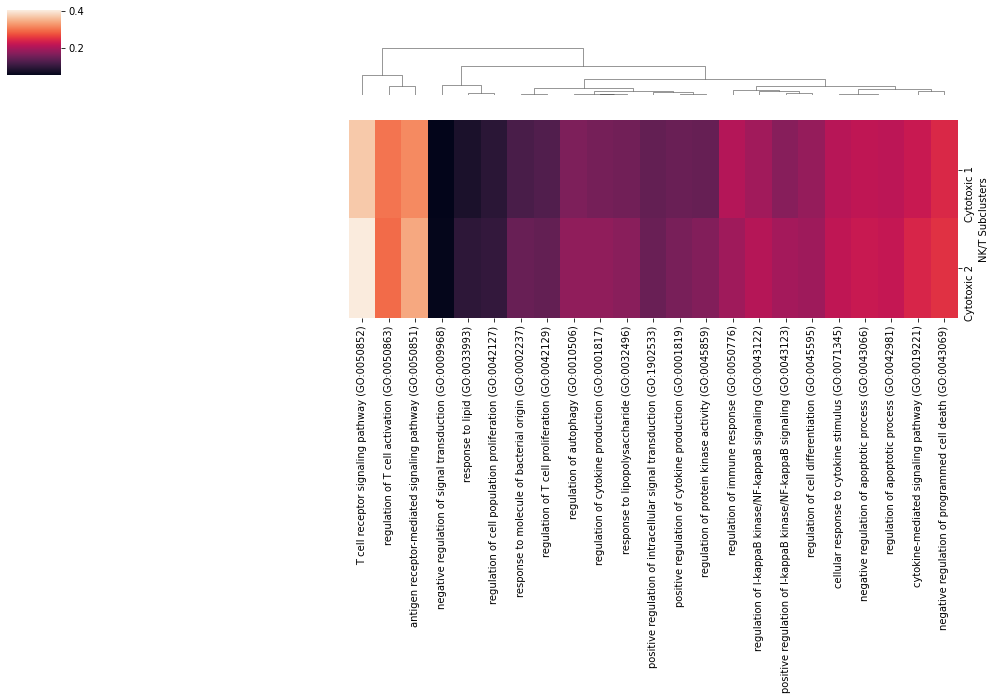

In [73]:
genelist_references = gh.get_genelist_references(reference_file_path = "enrichr_references/",gene_sets=["GO_Biological_Process_2021"])

cyt1_v_cyt2 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/GZMKCytotoxic1_vs_Cytotoxic2_subsets.csv",index_col=0)
cyt1_up,cyt2_up,cyt1_2_hits,hits_scored1,hits_scored2= differential_genes_enrichment_analysis(cyt1_v_cyt2, "Cytotoxic 1", "Cytotoxic 2", gene_sets = "GO_Biological_Process_2021")
cyt1_up,cyt2_up,cyt1_cyt2_deseq=filter_deseq_genes(cyt1_v_cyt2, "Cytotoxic 1", "Cytotoxic 2",t_adata_nodub,minlfc=0,min_padj = 1)
cyt1_cyt2_deseq = cyt1_cyt2_deseq.loc[list(cyt1_up.index)+list(cyt2_up.index)]
#rename LOCs to make visualization/enrichment easier
cyt1_cyt2_deseq.loc[cyt1_cyt2_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"] = [fmp.LOCs[i] for i in cyt1_cyt2_deseq.loc[cyt1_cyt2_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]]
cyt1_cyt2_deseq.index = cyt1_cyt2_deseq["newindex"]
#cyt1_cyt2_deseq.to_csv("tables/differential_genes/t_cells/pairwise_comparisons/pct_filtered/GZMKCytotoxic1_vs_Cytotoxic2_deseq_pct_filtered.csv")

In [202]:
cyt1_cyt2_deseq.loc[cyt1_cyt2_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"] = [fmp.LOCs[i] for i in cyt1_cyt2_deseq.loc[cyt1_cyt2_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]]

In [215]:
cyt1_cyt2_deseq.loc[cyt1_cyt2_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]

Series([], Name: newindex, dtype: object)

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['regulation of immune response (GO:0050776)'
 'positive regulation of myeloid leukocyte cytokine production involved in immune response (GO:0061081)'
 'positive regulation of smooth muscle cell proliferation (GO:0048661)'
 'regulation of smooth muscle cell proliferation (GO:0048660)'
 'positive regulation of natural killer cell mediated cytotoxicity (GO:0045954)']
['cytokine-mediated signaling pathway (GO:0019221)'
 'cellular response to cytokine stimulus (GO:0071345)'
 'regulation of T cell activation (GO:0050863)'
 'positive regulation of I-kappaB kinase/NF-kappaB signaling (GO:0043123)'
 'cellular response to interleukin-2 (GO:0071352)']
regulation of immune response (GO:0050776)
cytokine-mediated signaling pathway (GO:0019221)
cellular response to cytokine stimulus (GO:0071345)
regulation of 

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


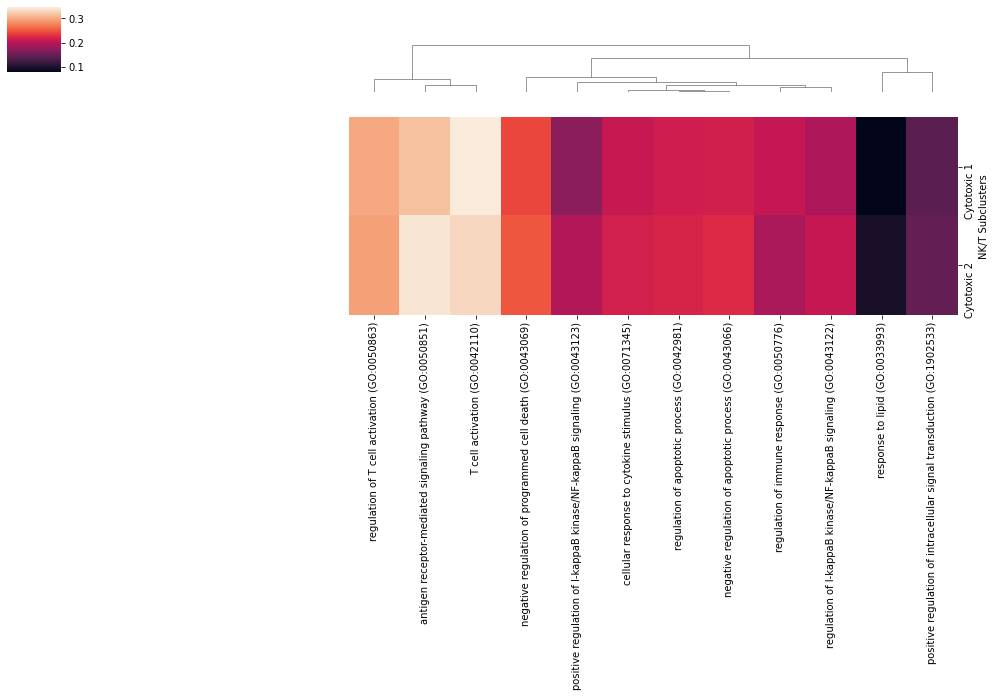

In [160]:
cyt1_v_cyt2 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/GZMKCytotoxic1_vs_Cytotoxic2_subsets.csv",index_col=0)
cyt1_up,cyt2_up,cyt1_2_hits= differential_genes_enrichment_analysis(cyt1_v_cyt2, "Cytotoxic 1", "Cytotoxic 2", gene_sets = "GO_Biological_Process_2021")

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
['positive regulation of cAMP-dependent protein kinase activity (GO:2000481)'
 'toll-like receptor 9 signaling pathway (GO:0034162)'
 'regulation of cAMP-dependent protein kinase activity (GO:2000479)'
 'defense response to protozoan (GO:0042832)'
 'protein autoprocessing (GO:0016540)']
['cytokine-mediated signaling pathway (GO:0019221)'
 'T cell receptor signaling pathway (GO:0050852)'
 'antigen receptor-mediated signaling pathway (GO:0050851)'
 'positive regulation of intracellular signal transduction (GO:1902533)'
 'mesodermal cell differentiation (GO:0048333)']
cytokine-mediated signaling pathway (GO:0019221)
T cell receptor signaling pathway (GO:0050852)
antigen receptor-mediated signaling pathway (GO:0050851)
positive regulation of intracellular signal transduction (GO:1902533)
positive regu

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


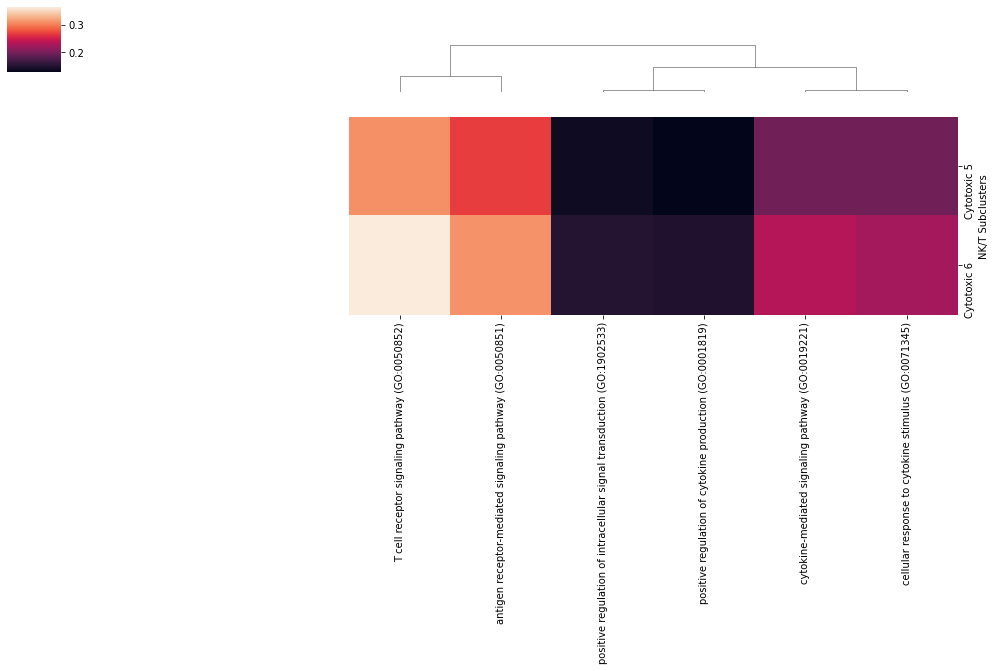

In [76]:
cyt6_v_cyt5 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/KLF3Cytotoxic6_vs_Cytotoxic5_subsets.csv",index_col=0)

cyt5_up,cyt6_up,cyt6_5_hits,cyt5_go,cyt6_go= differential_genes_enrichment_analysis(cyt6_v_cyt5, "Cytotoxic 5", "Cytotoxic 6", gene_sets = "GO_Biological_Process_2021")

#cyt6_up,cyt5_up,cyt6_cyt5_deseq=filter_deseq_genes(cyt6_v_cyt5, "Cytotoxic 6", "Cytotoxic 5",t_adata_nodub,minlfc=0,min_padj = 1)
#cyt6_cyt5_deseq = cyt6_cyt5_deseq.loc[list(cyt6_up.index)+list(cyt5_up.index)]
#rename LOCs to make visualization/enrichment easier
#cyt6_cyt5_deseq.loc[cyt6_cyt5_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"] = [fmp.LOCs[i] for i in cyt6_cyt5_deseq.loc[cyt6_cyt5_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]]
#cyt6_cyt5_deseq.index = cyt6_cyt5_deseq["newindex"]
#cyt6_cyt5_deseq.to_csv("tables/differential_genes/t_cells/pairwise_comparisons/pct_filtered/KLF3Cytotoxic6_vs_Cytotoxic5_deseq_pct_filtered.csv")

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
['regulation of immune response (GO:0050776)'
 'positive thymic T cell selection (GO:0045059)'
 'T cell receptor signaling pathway (GO:0050852)'
 'antigen receptor-mediated signaling pathway (GO:0050851)'
 'negative regulation of heterotypic cell-cell adhesion (GO:0034115)']


['antigen receptor-mediated signaling pathway (GO:0050851)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'neutrophil mediated immunity (GO:0002446)'
 'regulation of hippocampal neuron apoptotic process (GO:0110089)']
regulation of immune response (GO:0050776)
T cell receptor signaling pathway (GO:0050852)
antigen receptor-mediated signaling pathway (GO:0050851)
antigen receptor-mediated signaling pathway (GO:0050851)
neutrophil degranulation (GO:0043312)
neutrophil activation involved in immune response (GO:0002283)
neutrophil mediated immunity (GO:0002446)
cellular defense response (GO:0006968)
positive regulation of reactive oxygen species metabolic process (GO:2000379)
cellular response to cytokine stimulus (GO:0071345)
positive regulation of cytokine production (GO:0001819)
cytokine-mediated signaling pathway (GO:0019221)
positive regulation of transcription by RNA polymerase II (GO:0045944)
regulation of I-kappaB kinas

positive regulation of transcription, DNA-templated (GO:0045893)
protein-containing complex subunit organization (GO:0043933)


regulation of immune response (GO:0050776)
positive regulation of cell migration (GO:0030335)
negative regulation of inflammatory response (GO:0050728)
negative regulation of apoptotic process (GO:0043066)
cellular response to interleukin-1 (GO:0071347)


positive regulation of NF-kappaB transcription factor activity (GO:0051092)
positive regulation of cellular process (GO:0048522)
cellular response to oxygen-containing compound (GO:1901701)


positive regulation of DNA-binding transcription factor activity (GO:0051091)


positive regulation of cellular biosynthetic process (GO:0031328)


protein-containing complex assembly (GO:0065003)


cellular response to tumor necrosis factor (GO:0071356)


negative regulation of programmed cell death (GO:0043069)
positive regulation of macromolecule metabolic process (GO:0010604)
regulation of signal transduction (GO:0009966)


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


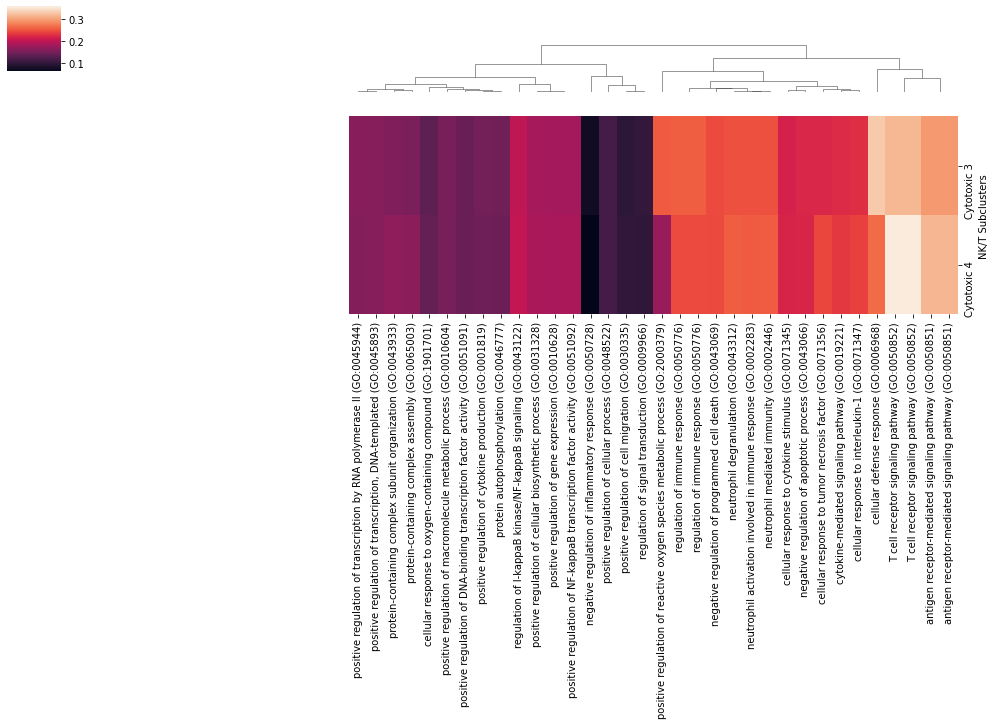

In [79]:

cyt3_v_cyt4 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/Cytotoxic3_Cytotoxic4_deseq2.csv",index_col=0)

cyt3_up,cyt4_up,cyt3_4_hits,cyt3_go,cyt4_go= differential_genes_enrichment_analysis(cyt3_v_cyt4, "Cytotoxic 3", "Cytotoxic 4", gene_sets = "GO_Biological_Process_2021")

#cyt3_up,cyt4_up,cyt3_cyt4_deseq=filter_deseq_genes(cyt3_v_cyt4, "Cytotoxic 3", "Cytotoxic 4",t_adata_nodub,minlfc=0,min_padj = 1)
#cyt3_cyt4_deseq = cyt3_cyt4_deseq.loc[list(cyt3_up.index)+list(cyt4_up.index)]
#rename LOCs to make visualization/enrichment easier
#cyt3_cyt4_deseq.loc[cyt3_cyt4_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"] = [fmp.LOCs[i] for i in cyt3_cyt4_deseq.loc[cyt3_cyt4_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]]
#cyt3_cyt4_deseq.index = cyt3_cyt4_deseq["newindex"]
#cyt3_cyt4_deseq.to_csv("tables/differential_genes/t_cells/pairwise_comparisons/pct_filtered/Cytotoxic3_Cytotoxic4_deseq_pct_filtered.csv")

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
['intrinsic apoptotic signaling pathway (GO:0097193)'
 'positive regulation of transcription, DNA-templated (GO:0045893)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'cellular response to cytokine stimulus (GO:0071345)'
 'positive regulation of transcription by RNA polymerase II (GO:0045944)']


['negative regulation of nucleic acid-templated transcription (GO:1903507)'
 'negative regulation of cellular macromolecule biosynthetic process (GO:2000113)'
 'negative regulation of amyloid precursor protein biosynthetic process (GO:0042985)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'negative regulation of glycoprotein biosynthetic process (GO:0010561)']
intrinsic apoptotic signaling pathway (GO:0097193)


positive regulation of transcription, DNA-templated (GO:0045893)
cytokine-mediated signaling pathway (GO:0019221)
cellular response to cytokine stimulus (GO:0071345)
positive regulation of transcription by RNA polymerase II (GO:0045944)
regulation of immune response (GO:0050776)
regulation of protein localization to plasma membrane (GO:1903076)


positive regulation of intracellular signal transduction (GO:1902533)
positive regulation of cell population proliferation (GO:0008284)
regulation of apoptotic process (GO:0042981)
regulation of I-kappaB kinase/NF-kappaB signaling (GO:0043122)
heart development (GO:0007507)
negative regulation of programmed cell death (GO:0043069)
negative regulation of nucleic acid-templated transcription (GO:1903507)
negative regulation of cellular macromolecule biosynthetic process (GO:2000113)
cytokine-mediated signaling pathway (GO:0019221)


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


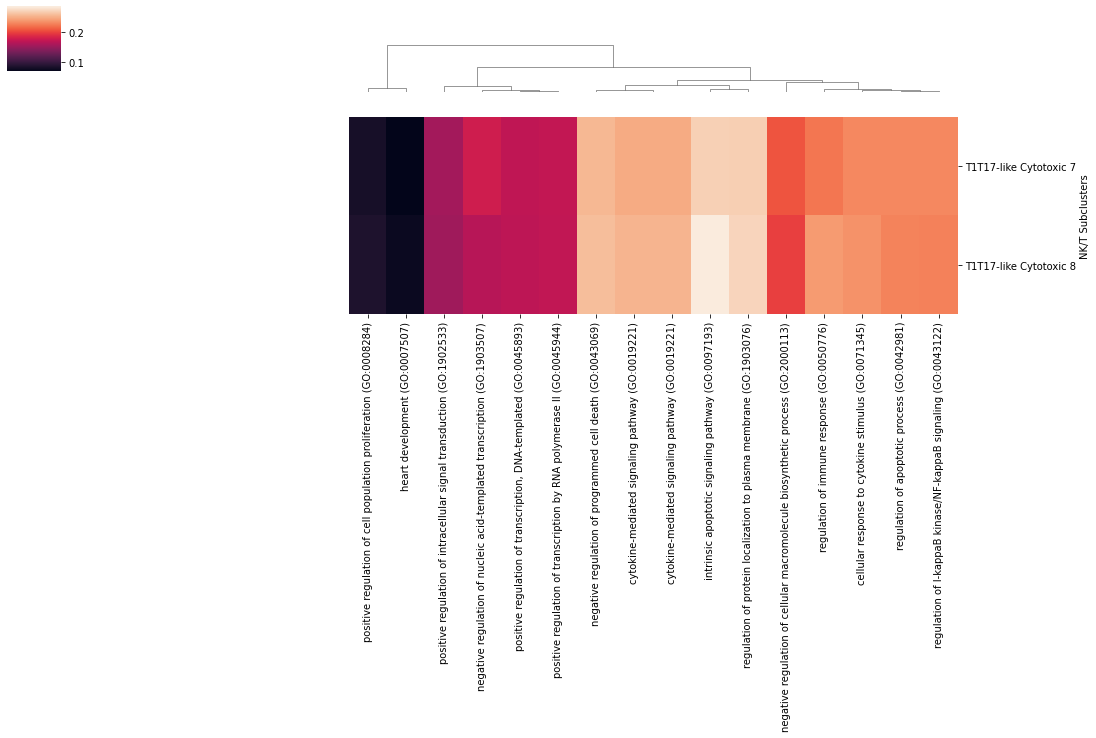

In [107]:

cyt7_v_cyt8 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/T1T17Cytotoxic8_Cytotoxic9_deseq2.csv",index_col=0)


cyt7_up,cyt8_up,cyt7_8_hits,cyt7_go,cyt8_go= differential_genes_enrichment_analysis(cyt7_v_cyt8, "T1T17-like Cytotoxic 7", "T1T17-like Cytotoxic 8", gene_sets = "GO_Biological_Process_2021")
#cyt7_up,cyt8_up,cyt7_cyt8_deseq=filter_deseq_genes(cyt7_v_cyt8,  "T1T17-like Cytotoxic 7", "T1T17-like Cytotoxic 8",t_adata_nodub,minlfc=0,min_padj = 1)
#cyt7_cyt8_deseq = cyt7_cyt8_deseq.loc[list(cyt7_up.index)+list(cyt8_up.index)]
##rename LOCs to make visualization/enrichment easier
#cyt7_cyt8_deseq.loc[cyt7_cyt8_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"] = [fmp.LOCs[i] for i in cyt7_cyt8_deseq.loc[cyt7_cyt8_deseq["newindex"].isin(fmp.LOCs.keys()),"newindex"]]
#cyt7_cyt8_deseq.index = cyt7_cyt8_deseq["newindex"]
#cyt7_cyt8_deseq.to_csv("tables/differential_genes/t_cells/pairwise_comparisons/pct_filtered/T1T17Cytotoxic8_Cytotoxic9_deseq_pct_filtered.csv")

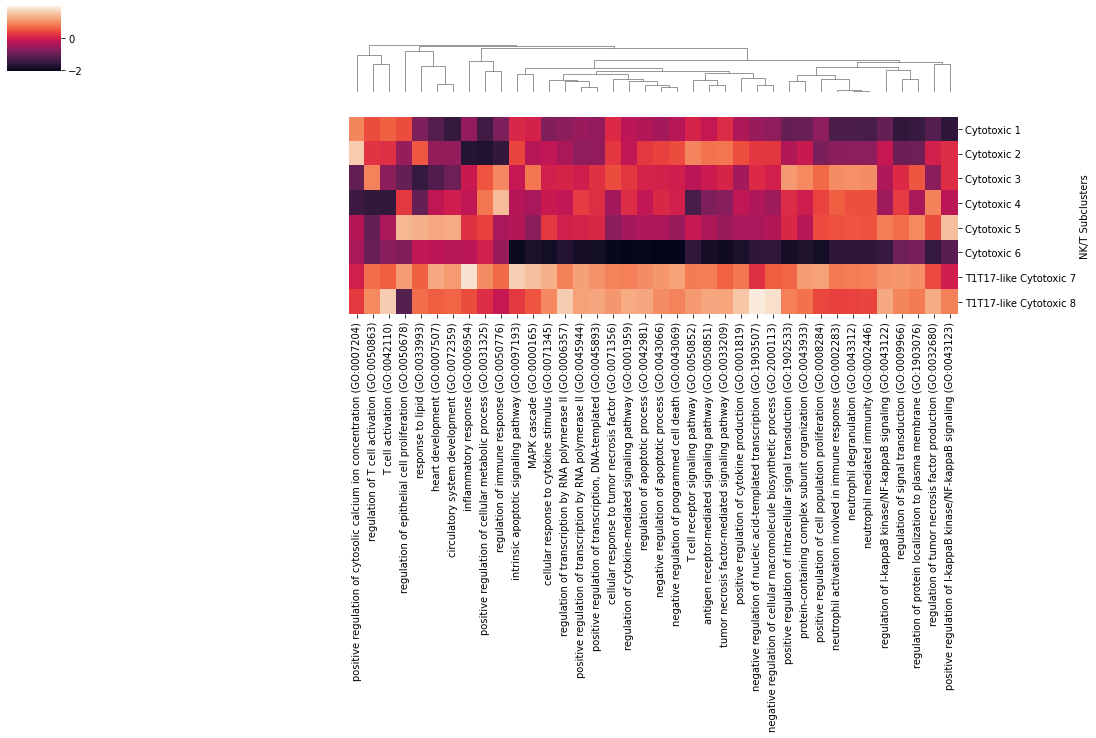

In [167]:
hits=list(set(cyt1_2_hits+cyt3_4_hits+cyt6_5_hits+cyt7_8_hits))
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(hits)].groupby(["NK/T Subclusters"]).mean().loc[["Cytotoxic 1","Cytotoxic 2","Cytotoxic 3","Cytotoxic 4","Cytotoxic 5","Cytotoxic 6","T1T17-like Cytotoxic 7","T1T17-like Cytotoxic 8"]],figsize=(15,5),z_score=1,row_cluster=False)


In [169]:
genelist_references = gh.get_genelist_references(reference_file_path = "/data/cb/nyquist/breast_milk/breastMilk/deeper_sequencing_analysis/scanpy_per_treatment/enrichr_references/",gene_sets=["MSigDB_Hallmark_2020"])



LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Allograft Rejection' 'TNF-alpha Signaling via NF-kB'
 'IL-2/STAT5 Signaling' 'Interferon Gamma Response'
 'Xenobiotic Metabolism']


['IL-2/STAT5 Signaling' 'Allograft Rejection' 'Apoptosis'
 'Interferon Gamma Response' 'IL-6/JAK/STAT3 Signaling']
Allograft Rejection


TNF-alpha Signaling via NF-kB


IL-2/STAT5 Signaling


Interferon Gamma Response


Xenobiotic Metabolism


IL-2/STAT5 Signaling
Allograft Rejection
Apoptosis


Interferon Gamma Response
IL-6/JAK/STAT3 Signaling


Hypoxia


Androgen Response


TNF-alpha Signaling via NF-kB
mTORC1 Signaling


Inflammatory Response


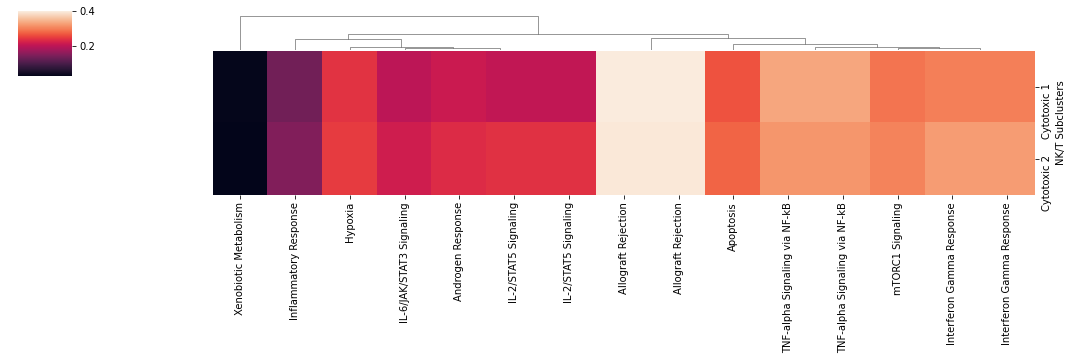

In [173]:
cyt1_v_cyt2 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/GZMKCytotoxic1_vs_Cytotoxic2_subsets.csv",index_col=0)
cyt1_up,cyt2_up,cyt1_2_hits= differential_genes_enrichment_analysis(cyt1_v_cyt2, "Cytotoxic 1", "Cytotoxic 2", gene_sets = "MSigDB_Hallmark_2020")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Allograft Rejection' 'Complement' 'Myogenesis' 'Estrogen Response Late'
 'heme Metabolism']
['TNF-alpha Signaling via NF-kB' 'Inflammatory Response'
 'Interferon Gamma Response' 'Mitotic Spindle' 'Allograft Rejection']
TNF-alpha Signaling via NF-kB
Inflammatory Response


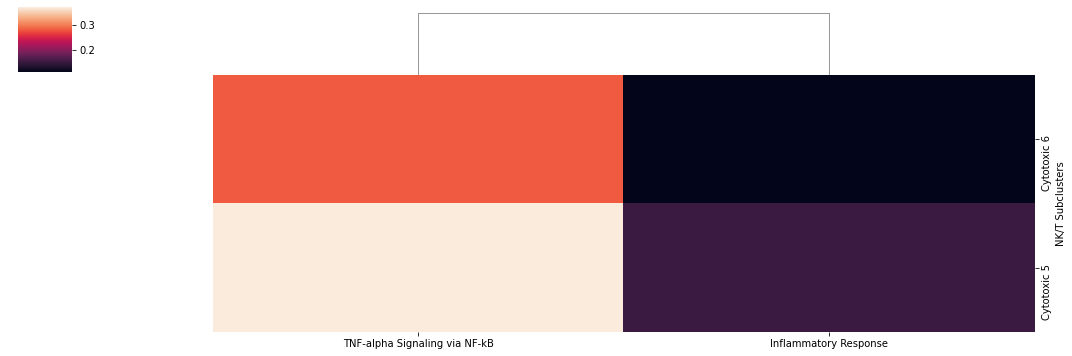

In [174]:
cyt6_v_cyt5 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/KLF3Cytotoxic6_vs_Cytotoxic5_subsets.csv",index_col=0)

cyt6_up,cyt5_up,cyt6_5_hits= differential_genes_enrichment_analysis(cyt6_v_cyt5, "Cytotoxic 6", "Cytotoxic 5", gene_sets = "MSigDB_Hallmark_2020")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Allograft Rejection' 'Interferon Gamma Response'
 'Interferon Alpha Response' 'IL-2/STAT5 Signaling'
 'Estrogen Response Early']


['TNF-alpha Signaling via NF-kB' 'IL-2/STAT5 Signaling'
 'Inflammatory Response' 'Interferon Gamma Response' 'Allograft Rejection']
Allograft Rejection
Interferon Gamma Response
TNF-alpha Signaling via NF-kB
IL-2/STAT5 Signaling
Inflammatory Response
Interferon Gamma Response
Allograft Rejection
Hypoxia
UV Response Up


Apoptosis
Complement


p53 Pathway


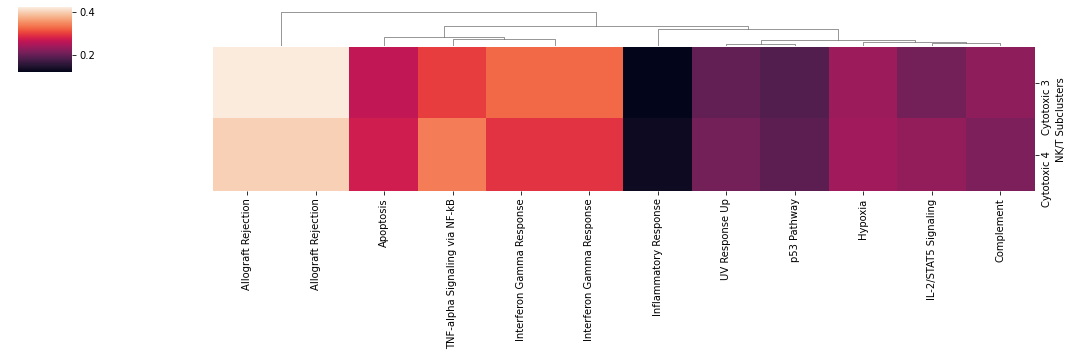

In [175]:

cyt3_v_cyt4 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/Cytotoxic3_Cytotoxic4_deseq2.csv",index_col=0)

cyt3_up,cyt4_up,cyt3_4_hits= differential_genes_enrichment_analysis(cyt3_v_cyt4, "Cytotoxic 3", "Cytotoxic 4", gene_sets = "MSigDB_Hallmark_2020")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['TNF-alpha Signaling via NF-kB' 'IL-2/STAT5 Signaling'
 'Allograft Rejection' 'Interferon Gamma Response' 'Hypoxia']


['IL-2/STAT5 Signaling' 'Allograft Rejection' 'Apoptosis'
 'Androgen Response' 'Interferon Gamma Response']
TNF-alpha Signaling via NF-kB
IL-2/STAT5 Signaling
Allograft Rejection
Interferon Gamma Response
Hypoxia
Apoptosis
mTORC1 Signaling
Inflammatory Response
PI3K/AKT/mTOR  Signaling


Estrogen Response Early


Complement
Epithelial Mesenchymal Transition
p53 Pathway
IL-2/STAT5 Signaling
Allograft Rejection
Apoptosis
Interferon Gamma Response
Inflammatory Response


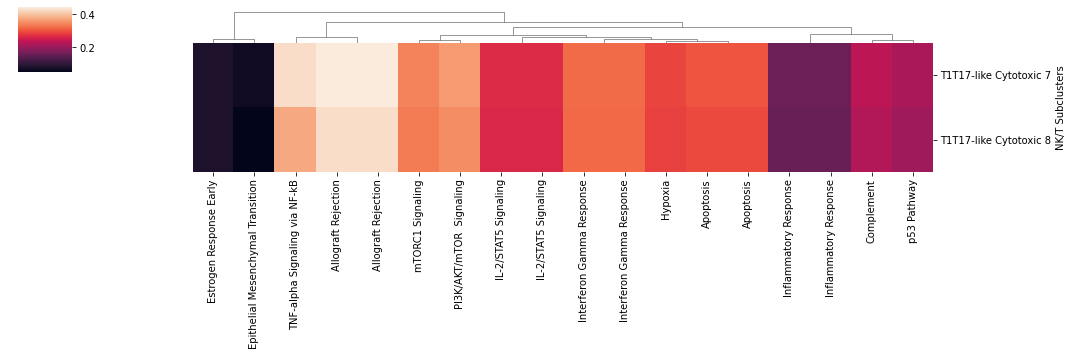

In [176]:

cyt7_v_cyt8 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/T1T17Cytotoxic8_Cytotoxic9_deseq2.csv",index_col=0)


cyt7_up,cyt8_up,cyt7_8_hits= differential_genes_enrichment_analysis(cyt7_v_cyt8, "T1T17-like Cytotoxic 7", "T1T17-like Cytotoxic 8", gene_sets = "MSigDB_Hallmark_2020")

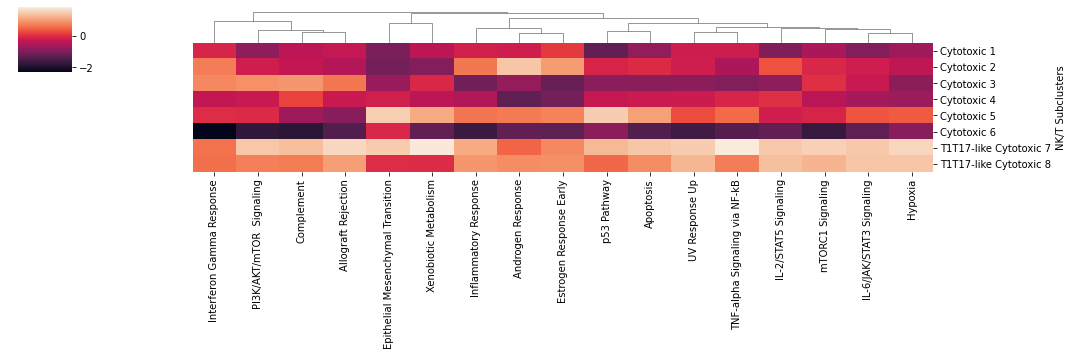

In [177]:
hits=list(set(cyt1_2_hits+cyt3_4_hits+cyt6_5_hits+cyt7_8_hits))
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(hits)].groupby(["NK/T Subclusters"]).mean().loc[["Cytotoxic 1","Cytotoxic 2","Cytotoxic 3","Cytotoxic 4","Cytotoxic 5","Cytotoxic 6","T1T17-like Cytotoxic 7","T1T17-like Cytotoxic 8"]],figsize=(15,5),z_score=1,row_cluster=False)


In [180]:
genelist_references = gh.get_genelist_references(reference_file_path = "/data/cb/nyquist/breast_milk/breastMilk/deeper_sequencing_analysis/scanpy_per_treatment/enrichr_references/",gene_sets=["KEGG_2021_Human"])



LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Apoptosis' 'Natural killer cell mediated cytotoxicity'
 'T cell receptor signaling pathway' 'Cocaine addiction'
 'NOD-like receptor signaling pathway']


['Measles' 'Th1 and Th2 cell differentiation' 'Th17 cell differentiation'
 'Human T-cell leukemia virus 1 infection'
 'Transcriptional misregulation in cancer']
Apoptosis
Measles


Th1 and Th2 cell differentiation


Th17 cell differentiation


Human T-cell leukemia virus 1 infection


Transcriptional misregulation in cancer


Cell adhesion molecules


T cell receptor signaling pathway


TNF signaling pathway


Necroptosis


JAK-STAT signaling pathway


MAPK signaling pathway


PD-L1 expression and PD-1 checkpoint pathway in cancer


Yersinia infection


Apoptosis
Pathways in cancer


Epstein-Barr virus infection


Hematopoietic cell lineage


Viral carcinogenesis


Viral protein interaction with cytokine and cytokine receptor


NF-kappa B signaling pathway


Lipid and atherosclerosis


Hepatitis B


Cytokine-cytokine receptor interaction


Osteoclast differentiation


FoxO signaling pathway


Endocytosis


Pathogenic Escherichia coli infection


Human immunodeficiency virus 1 infection


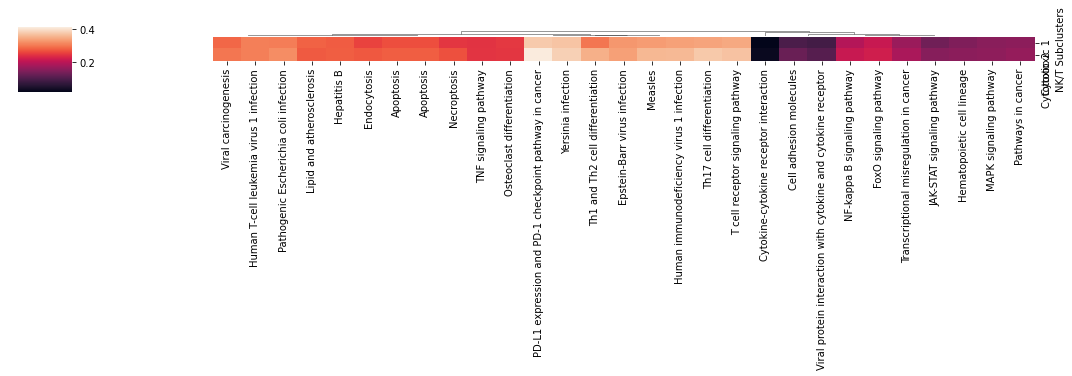

In [181]:
cyt1_v_cyt2 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/GZMKCytotoxic1_vs_Cytotoxic2_subsets.csv",index_col=0)
cyt1_up,cyt2_up,cyt1_2_hits= differential_genes_enrichment_analysis(cyt1_v_cyt2, "Cytotoxic 1", "Cytotoxic 2", gene_sets = "KEGG_2021_Human")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1


2021-08-24 10:45:32,164 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05


['Yersinia infection' 'Primary immunodeficiency'
 'Antigen processing and presentation' 'Hematopoietic cell lineage'
 'Chagas disease']


['Measles' 'Leishmaniasis'
 'PD-L1 expression and PD-1 checkpoint pathway in cancer'
 'Human papillomavirus infection' 'Epstein-Barr virus infection']
Measles
Human papillomavirus infection


Epstein-Barr virus infection
Coronavirus disease
Pathways in cancer


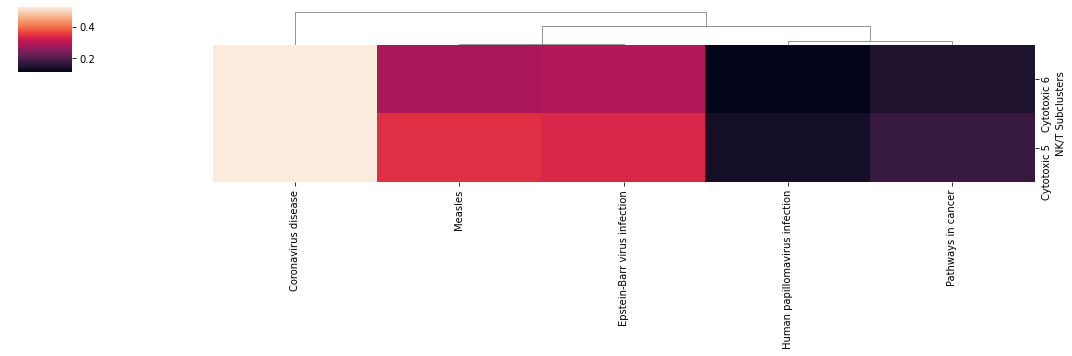

In [182]:
cyt6_v_cyt5 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/KLF3Cytotoxic6_vs_Cytotoxic5_subsets.csv",index_col=0)

cyt6_up,cyt5_up,cyt6_5_hits= differential_genes_enrichment_analysis(cyt6_v_cyt5, "Cytotoxic 6", "Cytotoxic 5", gene_sets = "KEGG_2021_Human")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Primary immunodeficiency' 'Hematopoietic cell lineage'
 'T cell receptor signaling pathway' 'Th17 cell differentiation'
 'Epstein-Barr virus infection']


['Th17 cell differentiation' 'TNF signaling pathway'
 'Transcriptional misregulation in cancer' 'Pathways in cancer'
 'Human T-cell leukemia virus 1 infection']
Epstein-Barr virus infection
Human immunodeficiency virus 1 infection
Th17 cell differentiation
TNF signaling pathway
Transcriptional misregulation in cancer
Pathways in cancer
Human T-cell leukemia virus 1 infection
Small cell lung cancer


Th1 and Th2 cell differentiation
Chemokine signaling pathway


Measles
Apoptosis
PD-L1 expression and PD-1 checkpoint pathway in cancer
Epstein-Barr virus infection
AGE-RAGE signaling pathway in diabetic complications


Chagas disease


Human cytomegalovirus infection


T cell receptor signaling pathway
JAK-STAT signaling pathway
HIF-1 signaling pathway


Osteoclast differentiation
Kaposi sarcoma-associated herpesvirus infection


PI3K-Akt signaling pathway


Viral carcinogenesis
Yersinia infection
Proteoglycans in cancer


Fluid shear stress and atherosclerosis


Human immunodeficiency virus 1 infection
Hepatitis B
Human papillomavirus infection
Influenza A


MAPK signaling pathway
Cytokine-cytokine receptor interaction
Lipid and atherosclerosis
Shigellosis


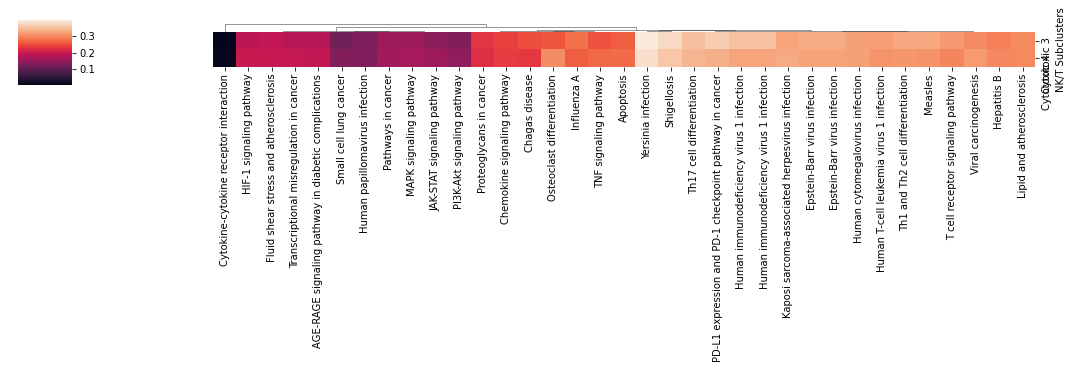

In [183]:

cyt3_v_cyt4 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/Cytotoxic3_Cytotoxic4_deseq2.csv",index_col=0)

cyt3_up,cyt4_up,cyt3_4_hits= differential_genes_enrichment_analysis(cyt3_v_cyt4, "Cytotoxic 3", "Cytotoxic 4", gene_sets = "KEGG_2021_Human")

LD5.1
NKX1.2
NKX3.1
NKX6.1
IFITM3.like..1
MAFA.F
NKX2.1
IFITM3.like..3
ERV3.1
NKX6.2
Mafa.B
NKX2.8
ERVFRD.1
NKX6.3
NKX1.1
IFITM3.like..2
NKX2.2
ERVMER34.1
NKX2.5
NKX2.4
NKX2.3
NKX3.2
GDNF.AS1
['Inflammatory bowel disease' 'Osteoclast differentiation'
 'Natural killer cell mediated cytotoxicity' 'Apoptosis'
 'Chronic myeloid leukemia']


['Cell adhesion molecules' 'Hematopoietic cell lineage'
 'PD-L1 expression and PD-1 checkpoint pathway in cancer'
 'Th1 and Th2 cell differentiation' 'Rheumatoid arthritis']
Inflammatory bowel disease


Osteoclast differentiation
Natural killer cell mediated cytotoxicity


Apoptosis
Acute myeloid leukemia


p53 signaling pathway


JAK-STAT signaling pathway
Human T-cell leukemia virus 1 infection
Chronic myeloid leukemia


Neurotrophin signaling pathway


Colorectal cancer


Autophagy


Transcriptional misregulation in cancer
Cellular senescence


TNF signaling pathway
MAPK signaling pathway
Pathways in cancer
Apelin signaling pathway
Cell adhesion molecules
Hematopoietic cell lineage
Transcriptional misregulation in cancer


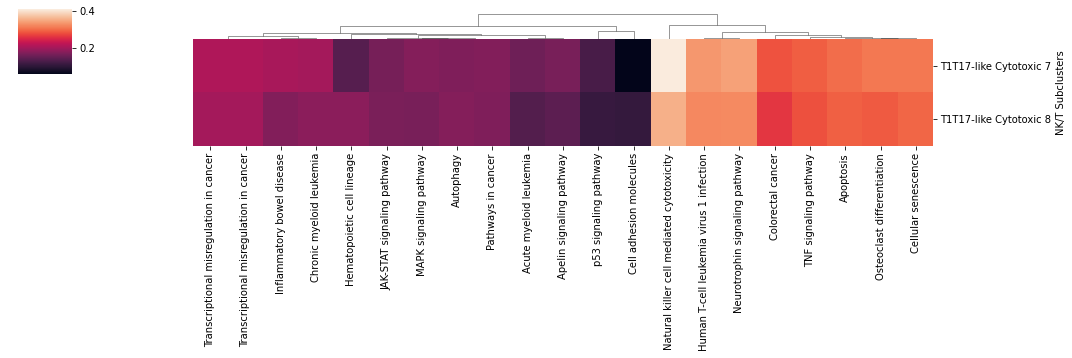

In [184]:

cyt7_v_cyt8 = pd.read_csv("tables/differential_genes/t_cells/pairwise_comparisons/T1T17Cytotoxic8_Cytotoxic9_deseq2.csv",index_col=0)


cyt7_up,cyt8_up,cyt7_8_hits= differential_genes_enrichment_analysis(cyt7_v_cyt8, "T1T17-like Cytotoxic 7", "T1T17-like Cytotoxic 8", gene_sets = "KEGG_2021_Human")

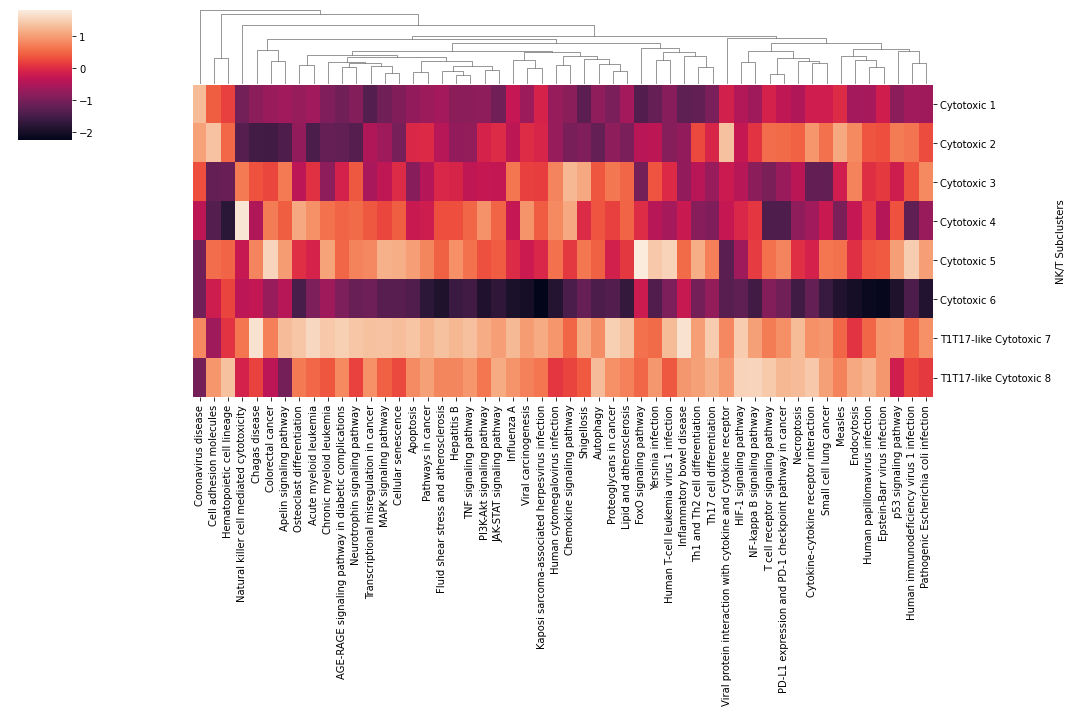

In [187]:
hits=list(set(cyt1_2_hits+cyt3_4_hits+cyt6_5_hits+cyt7_8_hits))
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(hits)].groupby(["NK/T Subclusters"]).mean().loc[["Cytotoxic 1","Cytotoxic 2","Cytotoxic 3","Cytotoxic 4","Cytotoxic 5","Cytotoxic 6","T1T17-like Cytotoxic 7","T1T17-like Cytotoxic 8"]],figsize=(15,10),z_score=1,row_cluster=False)


In [186]:
t_adata_nodub.obs.to_csv("t_adata_obs_with_geneset_scores.csv")

In [229]:
for i in cyt3_up.sort_values("log2FoldChange", ascending=False).head(100).index:
    print(i)

CD3E
LOC102128672
CD3D
TIGIT
CLIC5
CD3G
CCDC64
LIMS1
ETS2
CD96
GZMM
TOB1
COTL1
IKZF2
BEX1
CCR5
INPP4B
SORT1
SLAMF7
CENPF
VOPP1
BCL11B
GPR18
CRTAM
BCAT1
CNN2
WNK1
IRF4
TUBA4A
LOC102141127
LOC102144039
LOC102118347
GZMK
LOC102136468
CTSW
CLEC2D
ISG15
ST3GAL5
GGA2
SPINK2
CD52
CAMK4
MYADM
PPM1M
CD74
PRR5L
LOC102137968
LRIG1
LOC102135658
ATXN1
LOC102133757
APOBEC3H
SCML4
HIVEP2
GPRIN3
ORAI1
LMO4
TOPORS
LOC102115168
RILPL2
KCNA3
PIEZO1
DENND2D
ST3GAL1
LOC102124387
IFI27
FYN
ISG20
CDC14A
PAG1
LOC102137723
SH2D1A
RBM38
CD2
ANXA6
TRERF1
IDH2
APOL6
GPR174
FCMR
RHOH
GZF1
VIM
LOC102133263
SMARCE1
ITGB1
IGBP1
KIF3B
CD84
AGPAT3
F2R
ARHGAP18
CDC34
LOC102137336
M6PR
SFMBT2
LOC102138750
FYB
RGS19
SH3KBP1


In [195]:
for i in cyt8_up.sort_values("log2FoldChange", ascending=True).head(100).index:
    print(i)

CD4
CTLA4
PECAM1
ARID5B
SIT1
MAF
LOC101925857
FGL2
CTSH
SLAMF1
LOC102137336
IL2RA
LOC102137002
TRPS1
SUSD3
BATF
TNFSF10
CD28
TIGIT
CD5
NSMCE1
CSF1
PCED1B
EGLN3
SLA
CAPG
SLC4A7
SAMSN1
IL6ST
RGS1
ARL3
DUSP16
SCAPER
ITM2A
LOC102133263
CHD7
TRIM8
CD82
NDUFV3
CD2
THEMIS
FYB
ANTXR2
LRRC8C
LIMS1
CD6
PLEC
SPINT2
NR3C1
GIMAP7
SYT11
SPOCK2
ATP6V1B2
BIRC3
ANKFY1
N4BP2
MPHOSPH10
SEPT9
TSPO
MRPS34
ST6GAL1
INPP4B
MAP3K1
LGALS8
TMEM2
ITGB7
CYTH1
MDFIC
REXO2
FOXP1
RBPJ
MTG1
FRMD8
FOXO1
GPATCH8
AGO2
CDKN1B
GIMAP6
PTPN6
CORO7
IQGAP2
ZC3H4
TNKS2
ARID4A
LOC102137723
GAPVD1
ARHGAP9
UBA5
RBM25
PRPF6


# Cytotoxic Subset Marker Genes

In [124]:
def filter_deseq_marker_genes(pseudobulk, grps,t_adata_nodub,minlfc=.2,min_padj = 0.05):    
  
    overlap_genes = list(set(pseudobulk.index).intersection(t_adata_nodub.uns["rank_genes_groups"]["pts"].index))

    pseudobulk.loc[overlap_genes, "pts_grp1"] = t_adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,grps].max(axis=1)
    
    
    grp1_degenes = pseudobulk[(pseudobulk["padj"]<min_padj)&(pseudobulk["pts_grp1"] > .3)&(pseudobulk["log2FoldChange"] > minlfc)]
    return grp1_degenes,pseudobulk

def marker_genes_enrichment_analysis(des_res, grps, t_adata_nodub, gene_sets = "GO_Biological_Process_2021"):
    '''
    grps should be a list of group names in NK/T Subclusters
    '''
    rename_genes_R_messed_up(des_res, t_adata_nodub)
    
    minlfc = .5
    grps_up,_ = filter_deseq_marker_genes(des_res, grps,t_adata_nodub,minlfc)
    
    genes_gsea =  grps_up.sort_values('log2FoldChange').index
    print(len(genes_gsea)," differential genes")
    outdir='enrichr/'
    enr=gp.enrichr(list(genes_gsea), gene_sets,organism="human",outdir= outdir)
    enr.res2d["n_genes"] = [len(i.split(";")) for i in enr.res2d["Genes"]]

    
    


    GO_hits = enr.res2d.loc[(enr.res2d["Adjusted P-value"]<0.05)&(enr.res2d["n_genes"]>4),"Term"]
    print(len(GO_hits))
    hits=score_go_hits(GO_hits, genelist_references, t_adata_nodub,gene_sets)
    
   
    sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(hits)].groupby(["NK/T Subclusters"]).mean().loc[grps],figsize=(15,5),row_cluster=False)
    return grps_up,hits,enr.res2d.loc[(enr.res2d["Adjusted P-value"]<0.05)&(enr.res2d["n_genes"]>4)]


NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
159  differential genes
55
cellular response to cytokine stimulus (GO:0071345)
cytokine-mediated signaling pathway (GO:0019221)
canonical glycolysis (GO:0061621)
glucose catabolic process to pyruvate (GO:0061718)
glycolytic process through glucose-6-phosphate (GO:0061620)
apoptotic process (GO:0006915)
positive regulation of cytokine production (GO:0001819)
glycolytic process (GO:0006096)
regulation of fat cell differentiation (GO:0045598)
pyruvate metabolic process (GO:0006090)
regulation of apoptotic process (GO:0042981)
glucose metabolic process (GO:0006006)
carbohydrate catabolic process (GO:0016052)
gluconeogenesis (GO:0006094)
cellular response to decreased oxygen levels (GO:0036294)
hexose biosynthetic process (GO:0019319)
negative regulation of cellular macromolecule biosynthetic process (

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


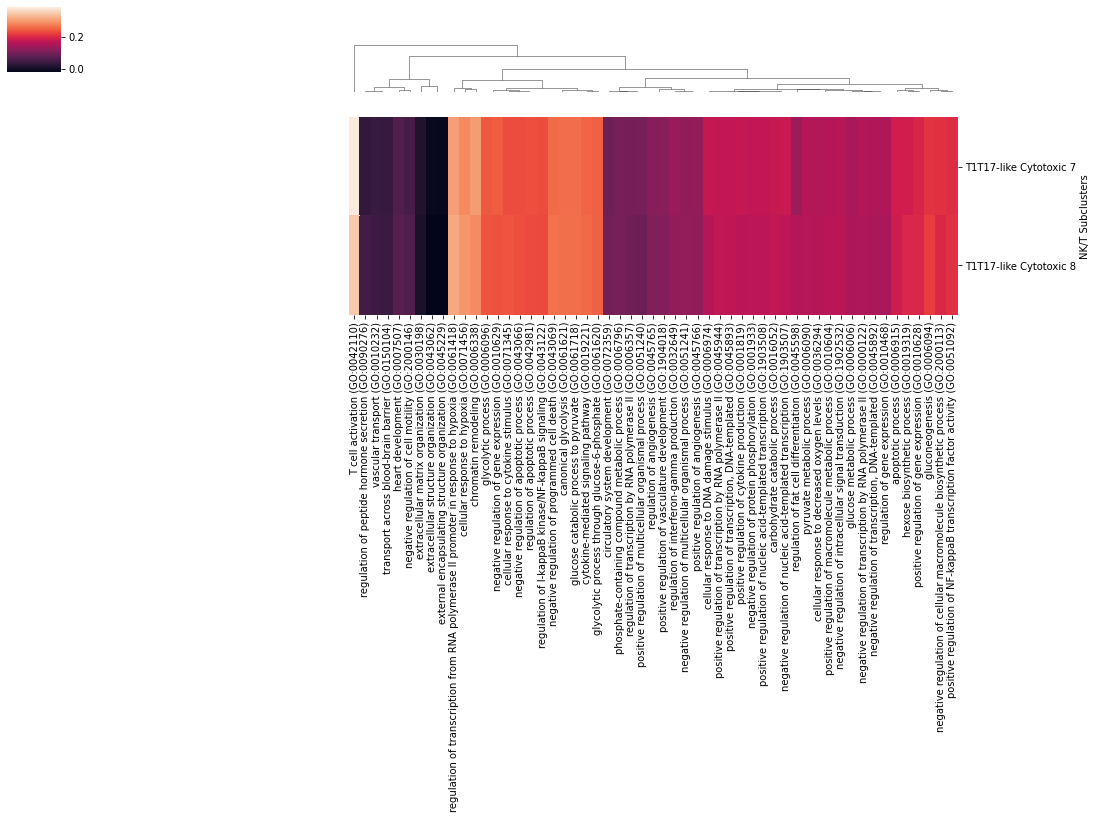

In [125]:
genelist_references = gh.get_genelist_references(reference_file_path = "/data/cb/nyquist/breast_milk/breastMilk/deeper_sequencing_analysis/scanpy_per_treatment/enrichr_references/",gene_sets=["GO_Biological_Process_2021"])

cyt7_8_markers = pd.read_csv("tables/differential_genes/t_cells/pseudobulk_marker_genes/cluster_T1T17-like Cytotoxic 8_T1T17-like Cytotoxic 9_marker_genes_pseudobulk.csv",index_col=0)
cyt7_8_up,cyt7_8_hits,cyt7_8_enr= marker_genes_enrichment_analysis(cyt7_8_markers, ["T1T17-like Cytotoxic 7", "T1T17-like Cytotoxic 8"],t_adata_nodub, gene_sets = "GO_Biological_Process_2021")


In [129]:
cyt7_8_enr.sort_values("Odds Ratio",ascending=False)

Gene_set  \
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
38  GO_Biological_Process_2021   
42  GO_Biological_Process_2021   
43  GO_Biological_Process_2021   
48  GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
66  GO_Biological_Process_2021   
67  GO_Biological_Process_2021   
36  GO_Biological_Process_2021   
0   GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
44  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
85  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
87  GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
68  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   
55  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
69  GO_Biological_Process_2021   
70  GO_Biological_Process_2021   
79  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
34  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
58  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
54  GO_Biological_Process_2021   
75  GO_Biological_Process_2021   
33  GO_Biological_Process_2021   
92  GO_Biological_Process_2021   
60  GO_Biological_Process_2021   
37  GO_Biological_Process_2021   
52  GO_Biological_Process_2021   
88  GO_Biological_Process_2021   
97  GO_Biological_Process_2021   
59  GO_Biological_Process_2021   

                                                 Term  Overlap       P-value  \
2                   canonical glycolysis (GO:0061621)     5/24  1.121514e-06   
3   glucose catabolic process to pyruvate (GO:0061...     5/24  1.121514e-06   
4   glycolytic process through glucose-6-phosphate...     5/25  1.392923e-06   
7                     glycolytic process (GO:0006096)     5/29  3.034538e-06   
12        carbohydrate catabolic process (GO:0016052)     5/41  1.773167e-05   
13                       gluconeogenesis (GO:0006094)     5/41  1.773167e-05   
16           hexose biosynthetic process (GO:0019319)     5/44  2.520741e-05   
9             pyruvate metabolic process (GO:0006090)     6/55  4.825855e-06   
11             glucose metabolic process (GO:0006006)     6/62  9.775229e-06   
8   regulation of fat cell differentiation (GO:004...     7/80  3.433250e-06   
14  cellular response to decreased oxygen levels (...     6/69  1.820893e-05   
26  regulation of peptide hormone secretion (GO:00...     5/74  3.087076e-04   
27  regulation of transcription from RNA polymeras...     5/75  3.286576e-04   
38                    vascular transport (GO:0010232)     5/84  5.551387e-04   
42  regulation of interferon-gamma production (GO:...     5/86  6.183290e-04   
43  transport across blood-brain barrier (GO:0150104)     5/86  6.183290e-04   
48                     T cell activation (GO:0042110)     5/92  8.404535e-04   
5                      apoptotic process (GO:0006915)   11/231  2.482203e-06   
66  positive regulation of vasculature development...    5/102  1.335939e-03   
67                  chromatin remodeling (GO:0006338)    5/103  1.395223e-03   
36        circulatory system development (GO:0072359)    6/126  5.159561e-04   
0   cellular response to cytokine stimulus (GO:007...   21/482  2.638762e-10   
24  negative regulation of protein phosphorylation...    7/152  2.168873e-04   
44          cellular response to hypoxia (GO:0071456)    6/131  6.337904e-04   
19            regulation of angiogenesis (GO:0045765)    9/203  3.666214e-05   
85  negative regulation of cell motil

In [183]:
go_excel_file = pd.ExcelWriter("tables/GO_hits_cytotoxic.xls")

In [185]:
cyt7_8_enr.sort_values("Odds Ratio",ascending=False).to_excel(go_excel_file, sheet_name="Cytotoxic 7 and 8")

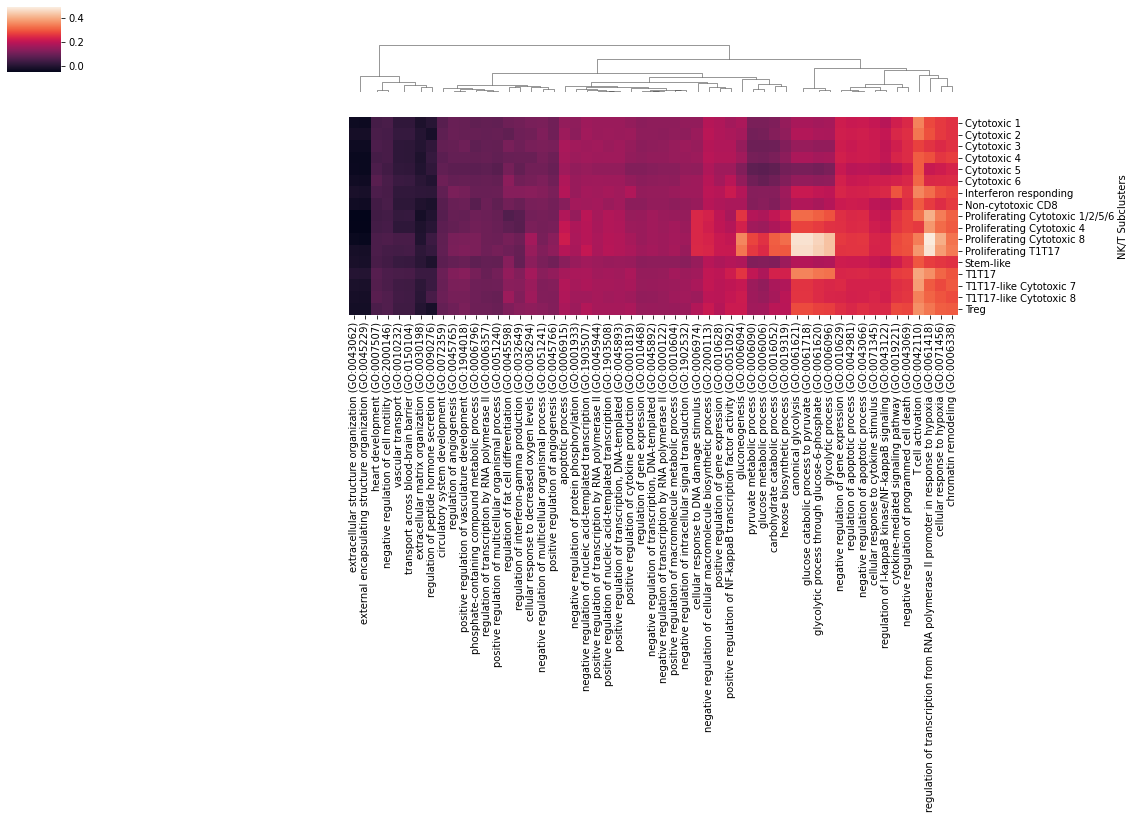

In [48]:
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(cyt7_8_hits)].groupby(["NK/T Subclusters"]).mean(),figsize=(15,5),row_cluster=False)

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
149  differential genes
2
Ras protein signal transduction (GO:0007265)
protein localization to membrane (GO:0072657)


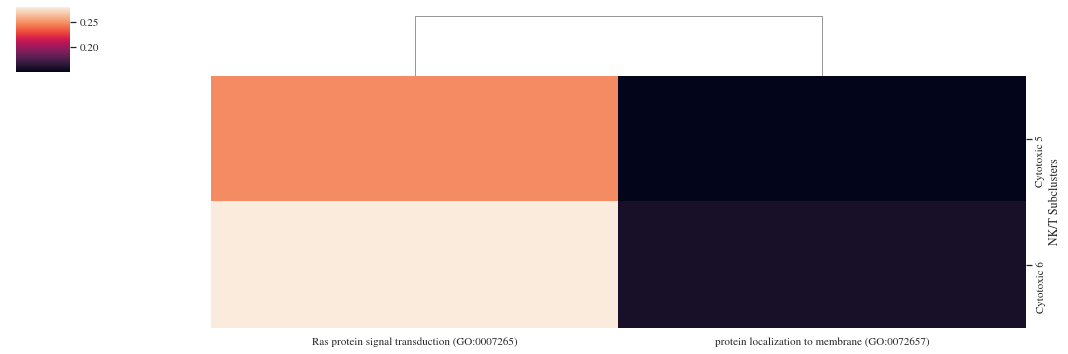

In [186]:

cyt5_6_markers = pd.read_csv("tables/differential_genes/t_cells/pseudobulk_marker_genes/cluster_Cytotoxic 5_Cytotoxic 6_marker_genes_pseudobulk.csv",index_col=0)
cyt5_6_up,cyt5_6_hits,cyt5_6_enr= marker_genes_enrichment_analysis(cyt5_6_markers, ["Cytotoxic 5", "Cytotoxic 6"],t_adata_nodub, gene_sets = "GO_Biological_Process_2021")


In [187]:
cyt5_6_enr.sort_values("Odds Ratio",ascending=False).to_excel(go_excel_file, sheet_name="Cytotoxic 5 and 6")

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
168  differential genes
41
positive regulation of cytokine production (GO:0001819)
regulation of B cell proliferation (GO:0030888)
cytokine-mediated signaling pathway (GO:0019221)
positive regulation of cytosolic calcium ion concentration (GO:0007204)
positive regulation of interleukin-2 production (GO:0032743)
positive regulation of lymphocyte proliferation (GO:0050671)
cellular response to cytokine stimulus (GO:0071345)
antigen receptor-mediated signaling pathway (GO:0050851)
response to lipopolysaccharide (GO:0032496)
T cell activation (GO:0042110)
regulation of T cell differentiation (GO:0045580)
regulation of cytosolic calcium ion concentration (GO:0051480)
positive regulation of T cell activation (GO:0050870)
regulation of T cell activation (GO:0050863)
regulation of interleukin-2 production

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


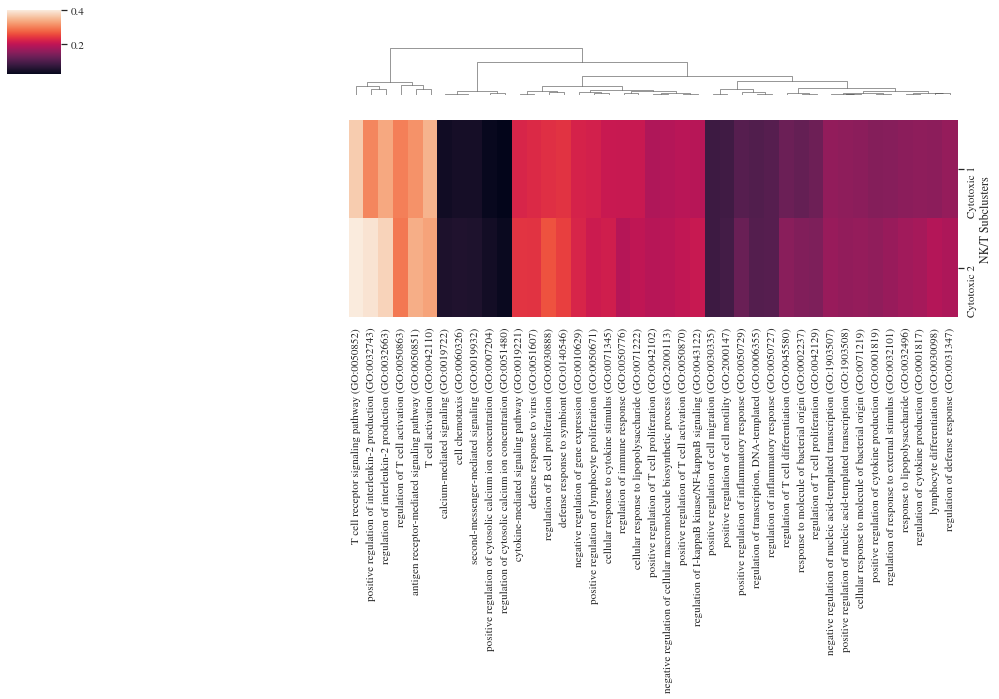

In [188]:
cyt1_2_markers = pd.read_csv("tables/differential_genes/t_cells/pseudobulk_marker_genes/cluster_Cytotoxic 1_Cytotoxic 2_marker_genes_pseudobulk.csv",index_col=0)
cyt1_2_up,cyt1_2_hits,cyt1_2_enr= marker_genes_enrichment_analysis(cyt1_2_markers, ["Cytotoxic 1", "Cytotoxic 2"],t_adata_nodub, gene_sets = "GO_Biological_Process_2021")
cyt1_2_enr.sort_values("Odds Ratio",ascending=False).to_excel(go_excel_file, sheet_name="Cytotoxic 1 and 2")

NKX2.1
NKX2.4
IFITM3.like..2
NKX6.2
NKX2.3
IFITM3.like..1
NKX2.8
MAFA.F
NKX1.1
GDNF.AS1
NKX2.5
NKX2.2
NKX1.2
NKX6.3
Mafa.B
ERVMER34.1
NKX6.1
ERVFRD.1
NKX3.1
ERV3.1
LD5.1
IFITM3.like..3
NKX3.2
196  differential genes
55
regulation of immune response (GO:0050776)
neutrophil activation involved in immune response (GO:0002283)
neutrophil degranulation (GO:0043312)
neutrophil mediated immunity (GO:0002446)
regulation of natural killer cell mediated cytotoxicity (GO:0042269)
Fc-gamma receptor signaling pathway (GO:0038094)
Fc receptor mediated stimulatory signaling pathway (GO:0002431)
peptidyl-tyrosine modification (GO:0018212)
antigen receptor-mediated signaling pathway (GO:0050851)
positive regulation of natural killer cell mediated immunity (GO:0002717)
regulation of innate immune response (GO:0045088)
positive regulation of leukocyte mediated cytotoxicity (GO:0001912)
peptidyl-tyrosine phosphorylation (GO:0018108)
positive regulation of cytokine production (GO:0001819)
Fc-gamma receptor

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


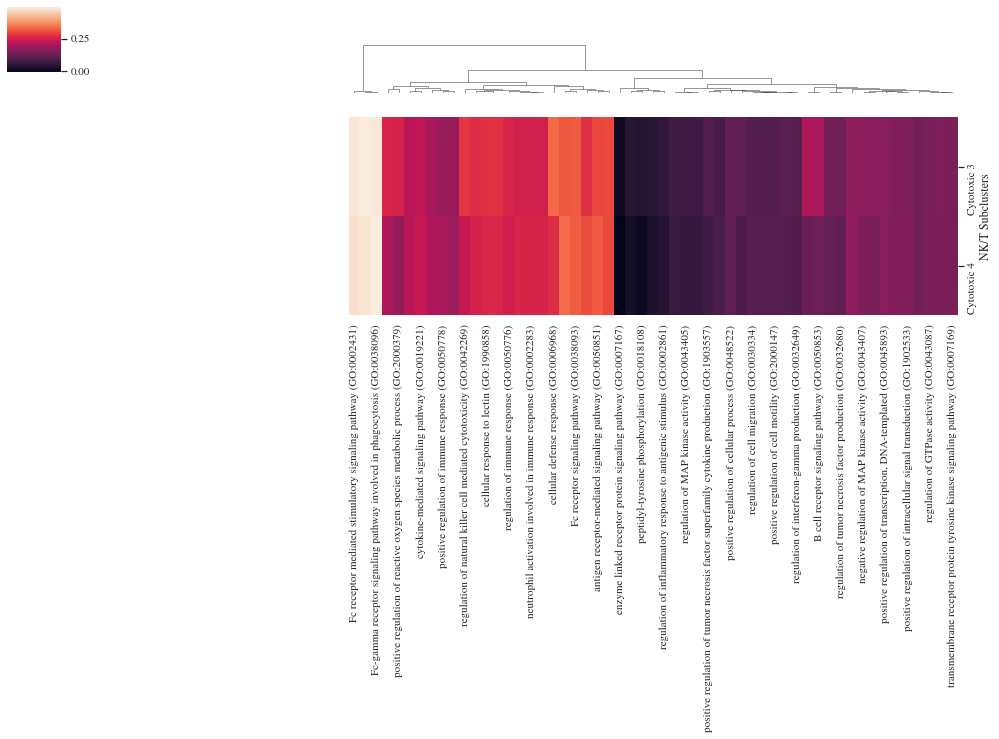

In [190]:
cyt3_4_markers = pd.read_csv("tables/differential_genes/t_cells/pseudobulk_marker_genes/cluster_Cytotoxic 3_Cytotoxic 4_marker_genes_pseudobulk.csv",index_col=0)
cyt3_4_up,cyt3_4_hits,cyt3_4_enr= marker_genes_enrichment_analysis(cyt3_4_markers, ["Cytotoxic 3", "Cytotoxic 4"],t_adata_nodub, gene_sets = "GO_Biological_Process_2021")
cyt3_4_enr.sort_values("Odds Ratio",ascending=False).to_excel(go_excel_file, sheet_name="Cytotoxic 3 and 4")

In [191]:
t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean().to_excel(go_excel_file, sheet_name="Mean GO GeneSet Scores")

In [192]:
go_excel_file.save()

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


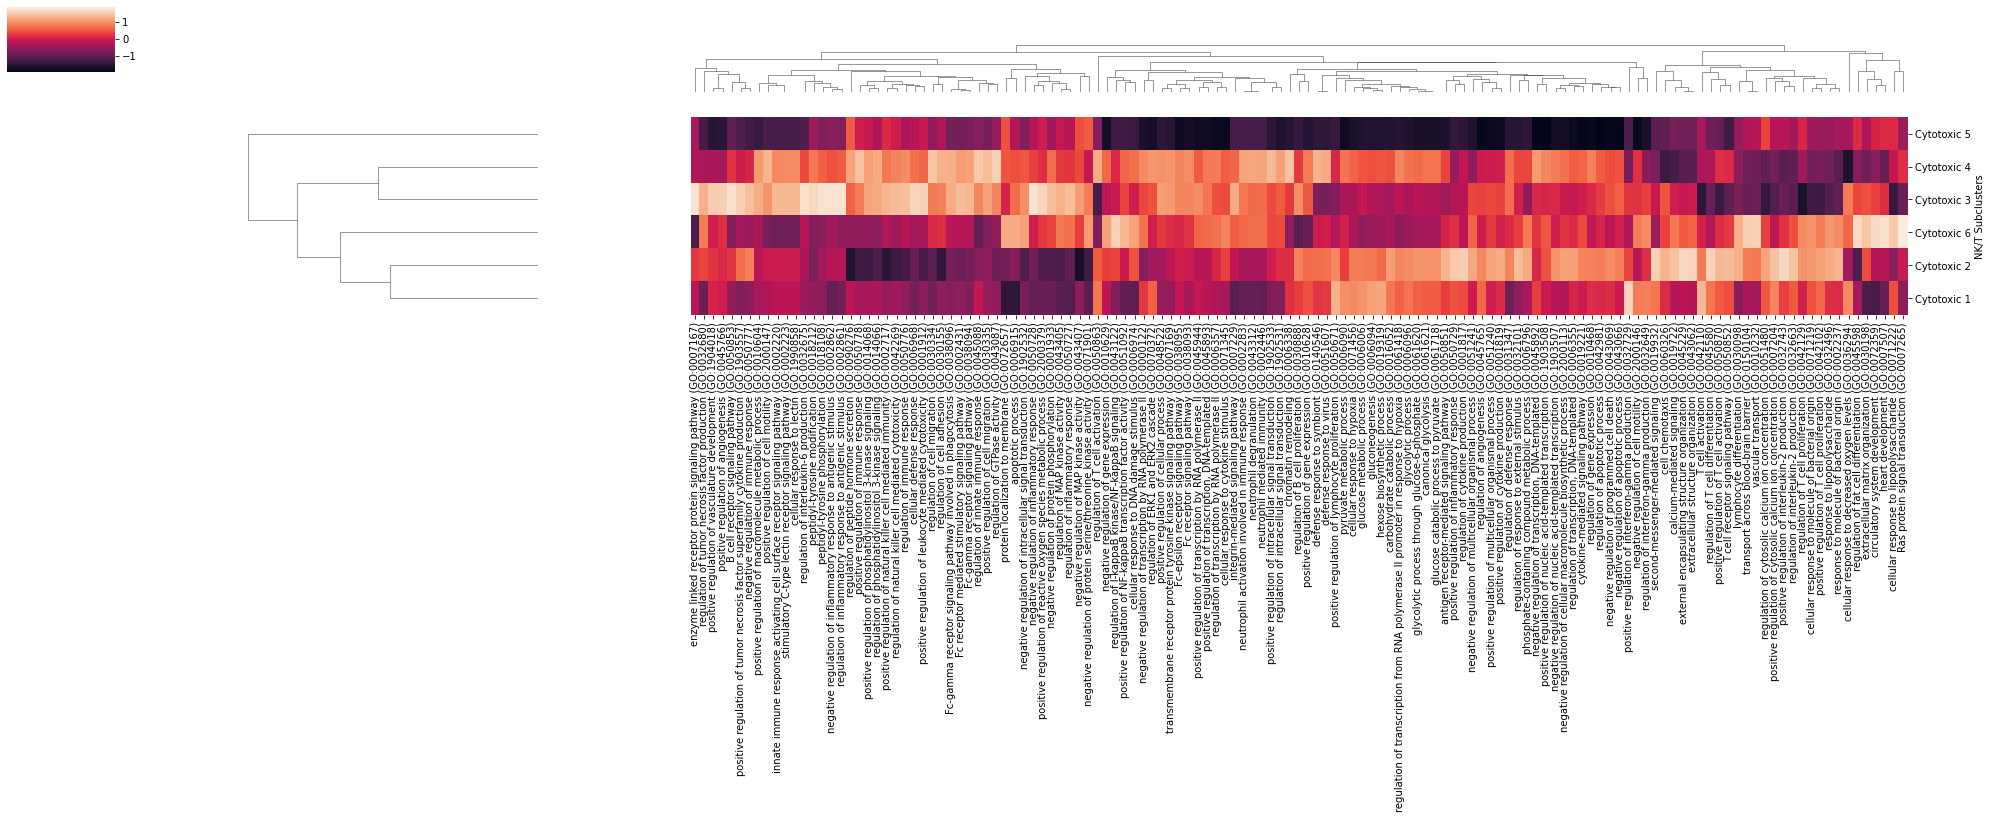

In [130]:
cyto_clusts_sub = ['Cytotoxic 4','Cytotoxic 3',
 'Cytotoxic 6',
 'Cytotoxic 2',
 'Cytotoxic 1','Cytotoxic 5']
g=sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts_sub],figsize=(30,5),row_cluster=True,z_score=1,xticklabels=1)

#plt.savefig("cyto_Go_res.pdf")

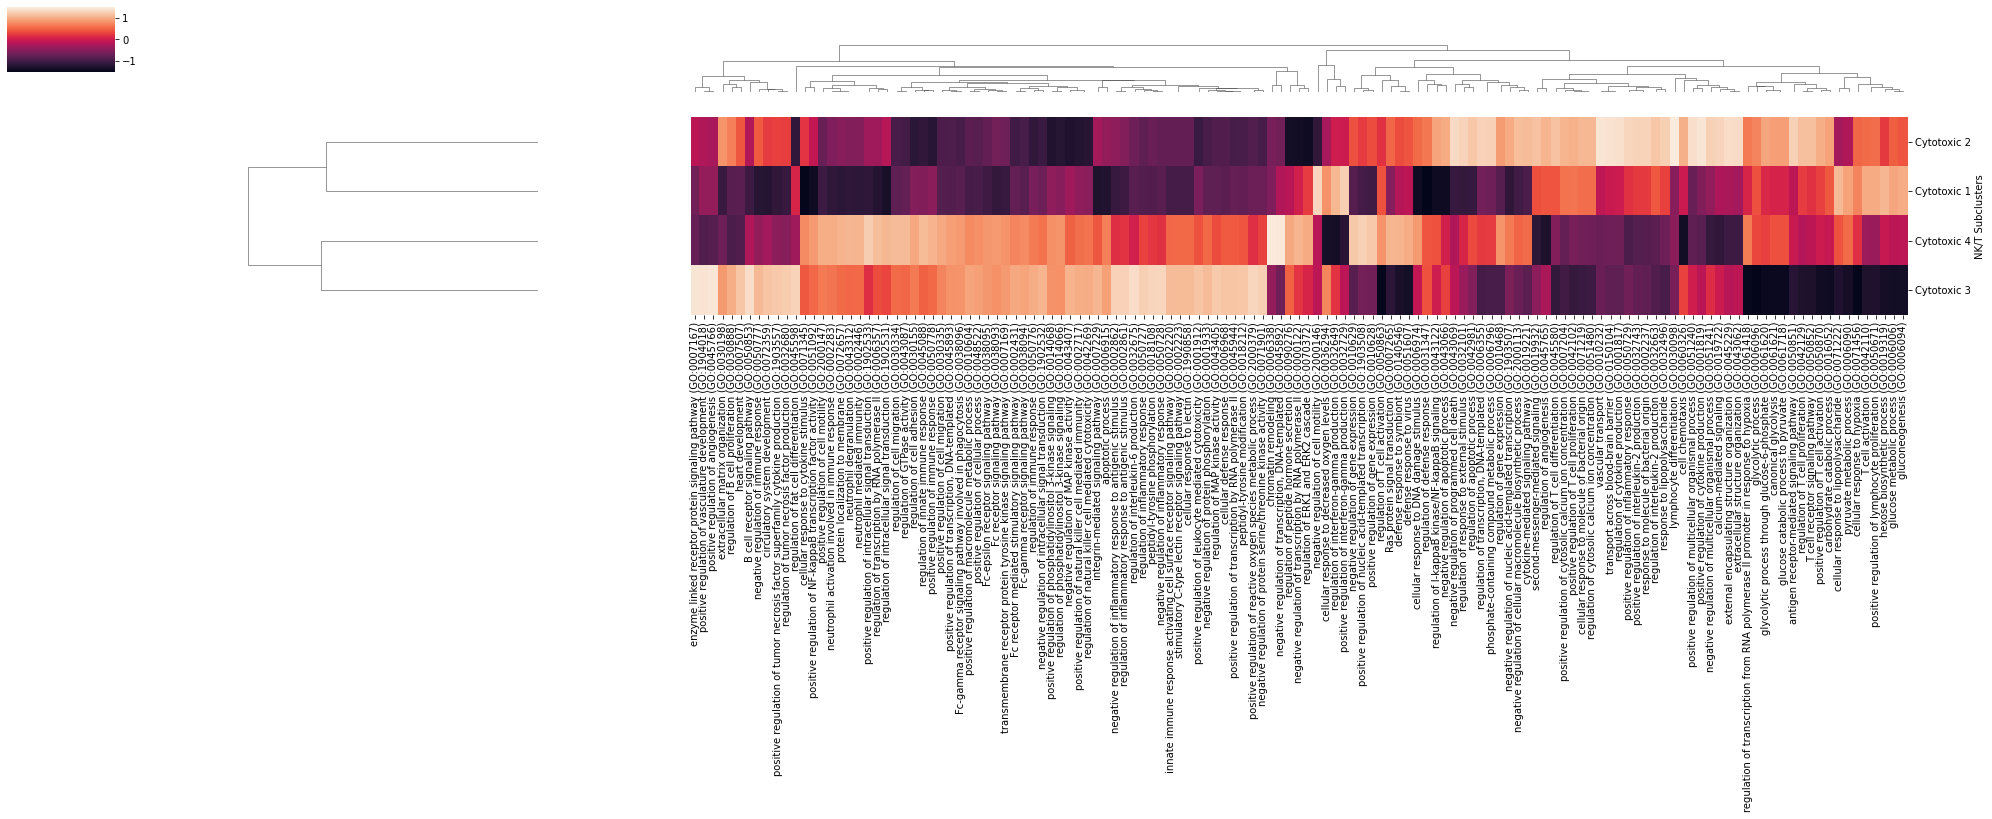

In [65]:
cyto_clusts_sub = ['Cytotoxic 4','Cytotoxic 3',
 'Cytotoxic 2',
 'Cytotoxic 1']
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts_sub],figsize=(30,5),row_cluster=True,z_score=1,xticklabels=1)


In [140]:
len(combined_hits)

133

In [146]:
reduced_hits=(t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts].var()/t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts].mean()).sort_values(ascending=False).head(70).index

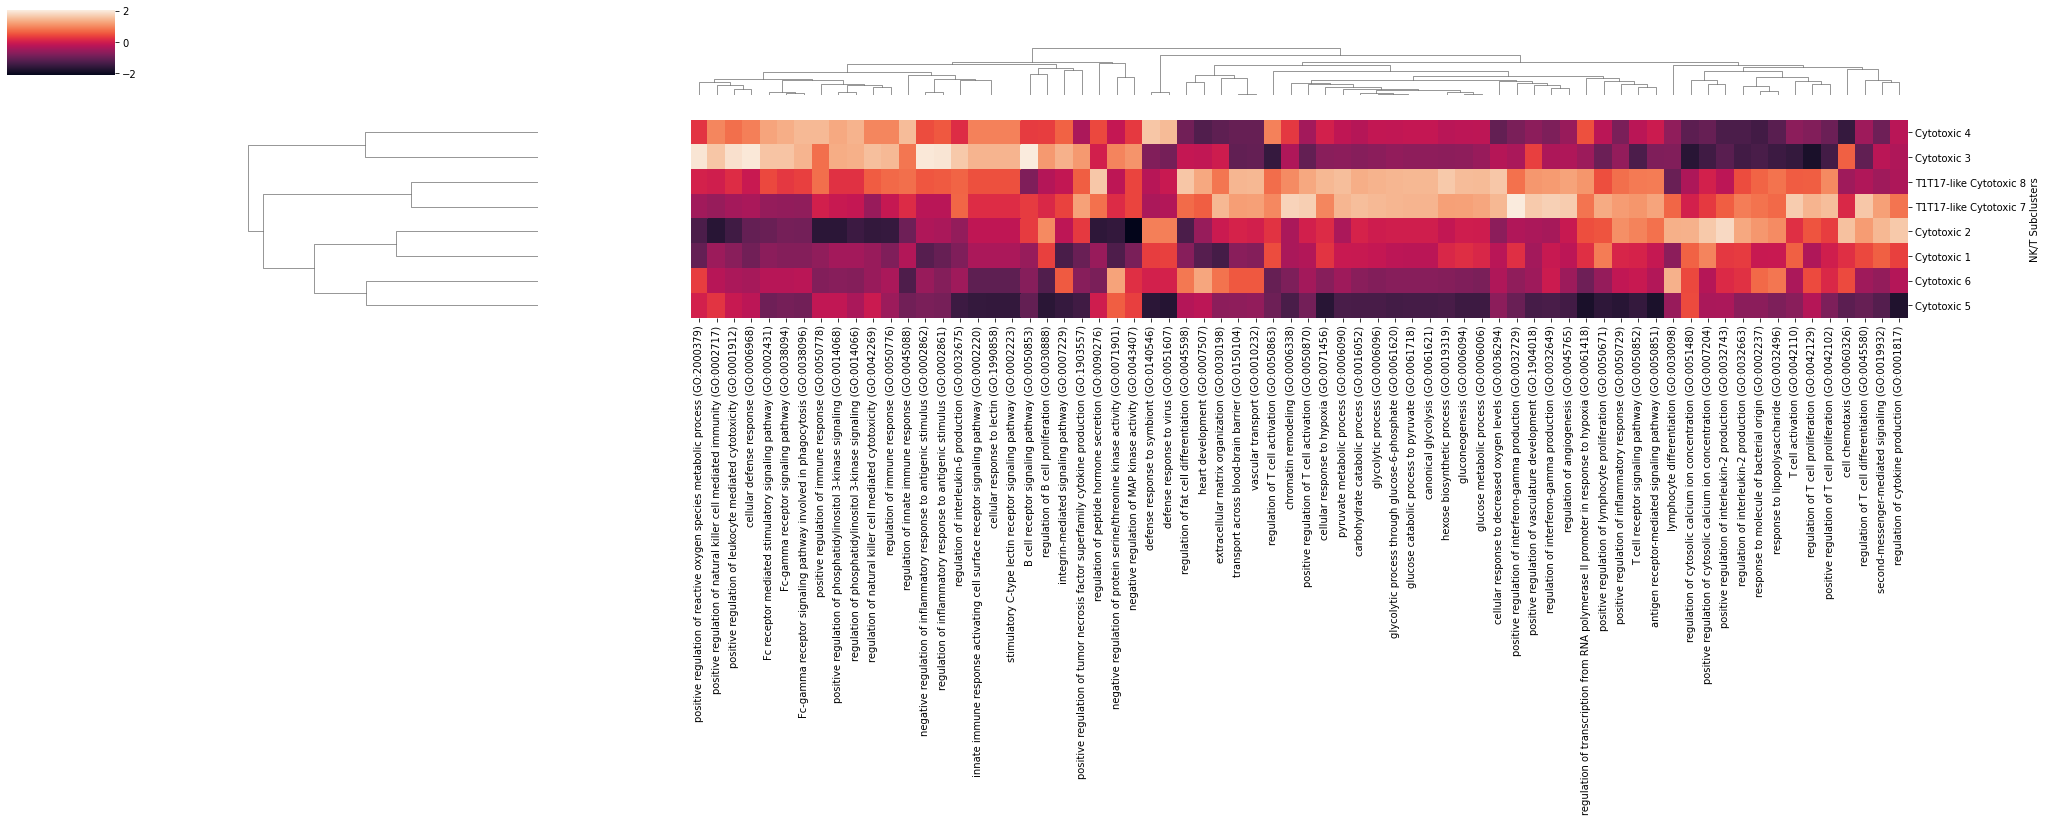

In [149]:
g=sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(reduced_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts],figsize=(30,5),row_cluster=True,z_score=1,xticklabels=1)


In [154]:
reduced_hits_2=['positive regulation of reactive oxygen species metabolic process (GO:2000379)',
 'positive regulation of natural killer cell mediated immunity (GO:0002717)',
 'positive regulation of leukocyte mediated cytotoxicity (GO:0001912)',
 'cellular defense response (GO:0006968)',
 'Fc receptor mediated stimulatory signaling pathway (GO:0002431)',
 'positive regulation of immune response (GO:0050778)',
 'positive regulation of phosphatidylinositol 3-kinase signaling (GO:0014068)',
 'regulation of natural killer cell mediated cytotoxicity (GO:0042269)',
 'negative regulation of inflammatory response to antigenic stimulus (GO:0002862)',
 'regulation of interleukin-6 production (GO:0032675)',
 'innate immune response activating cell surface receptor signaling pathway (GO:0002220)',
 'B cell receptor signaling pathway (GO:0050853)',
 'regulation of B cell proliferation (GO:0030888)',
 'integrin-mediated signaling pathway (GO:0007229)',
 'positive regulation of tumor necrosis factor superfamily cytokine production (GO:1903557)',
 'regulation of peptide hormone secretion (GO:0090276)',
 'negative regulation of MAP kinase activity (GO:0043407)',
 'defense response to symbiont (GO:0140546)',
 'extracellular matrix organization (GO:0030198)',
 'vascular transport (GO:0010232)',
 'chromatin remodeling (GO:0006338)',
 'positive regulation of T cell activation (GO:0050870)',
 'cellular response to hypoxia (GO:0071456)',
 'glycolytic process (GO:0006096)',
 'cellular response to decreased oxygen levels (GO:0036294)',
 'positive regulation of interferon-gamma production (GO:0032729)',
 'positive regulation of vasculature development (GO:1904018)',
 'positive regulation of lymphocyte proliferation (GO:0050671)',
 'positive regulation of inflammatory response (GO:0050729)',
 'T cell receptor signaling pathway (GO:0050852)',
 'lymphocyte differentiation (GO:0030098)',
 'positive regulation of cytosolic calcium ion concentration (GO:0007204)',
 'positive regulation of interleukin-2 production (GO:0032743)',
 'response to molecule of bacterial origin (GO:0002237)',
 'positive regulation of T cell proliferation (GO:0042102)',
 'cell chemotaxis (GO:0060326)',
 'regulation of T cell differentiation (GO:0045580)',
 'second-messenger-mediated signaling (GO:0019932)',
 'regulation of cytokine production (GO:0001817)']

In [177]:
"Times" in font_names

False

In [179]:
sns.set(font='STIXGeneral')

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  import sys


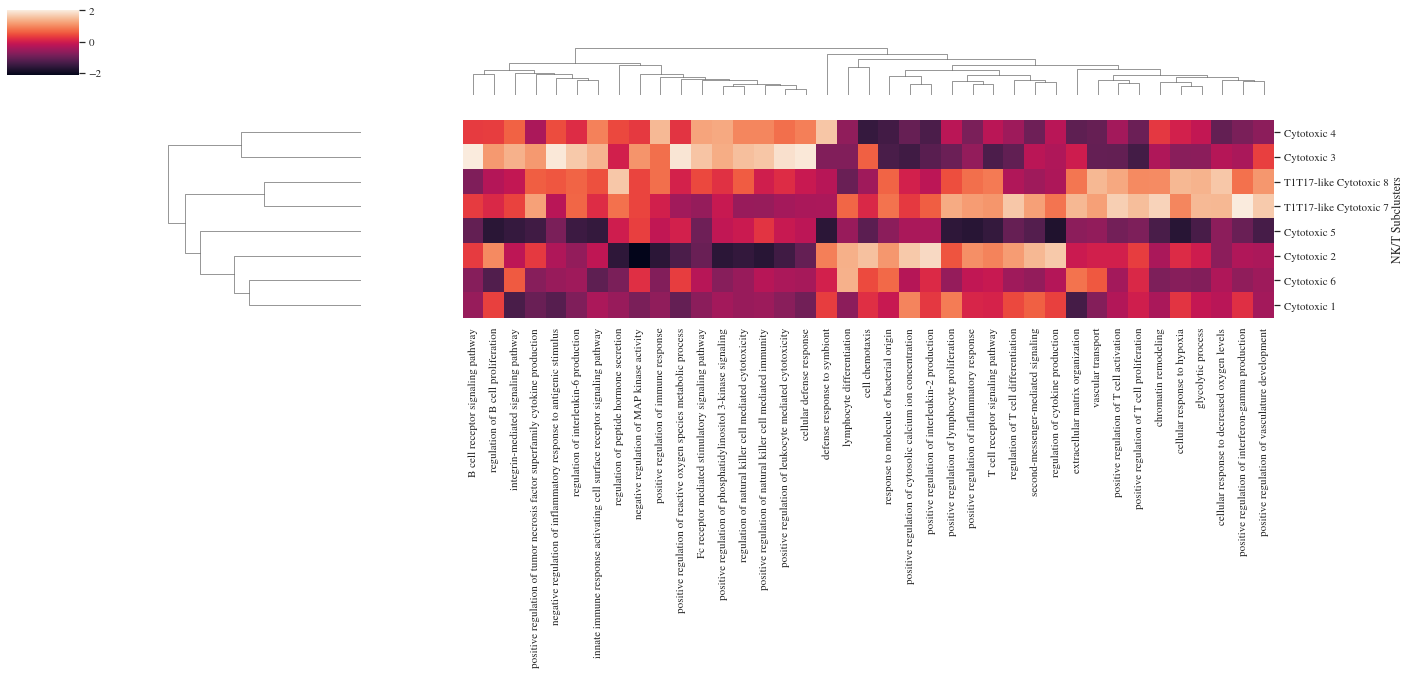

In [181]:
g=sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(reduced_hits_2)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts],figsize=(20,5),row_cluster=True,z_score=1,xticklabels=1)
new_labels= []
for t in g.ax_heatmap.get_xmajorticklabels():
    t.set_text(t.get_text().split(" (")[0])
    new_labels.append(t)
g.ax_heatmap.set_xticklabels(new_labels)
plt.tight_layout()
plt.savefig("GO_hits_cytotoxic_reduced.pdf",bbox_inches="tight")

In [162]:
t=g.ax_heatmap.get_xmajorticklabels()[0]

In [167]:
t.get_text()

'B cell receptor signaling pathway (GO:0050853)'

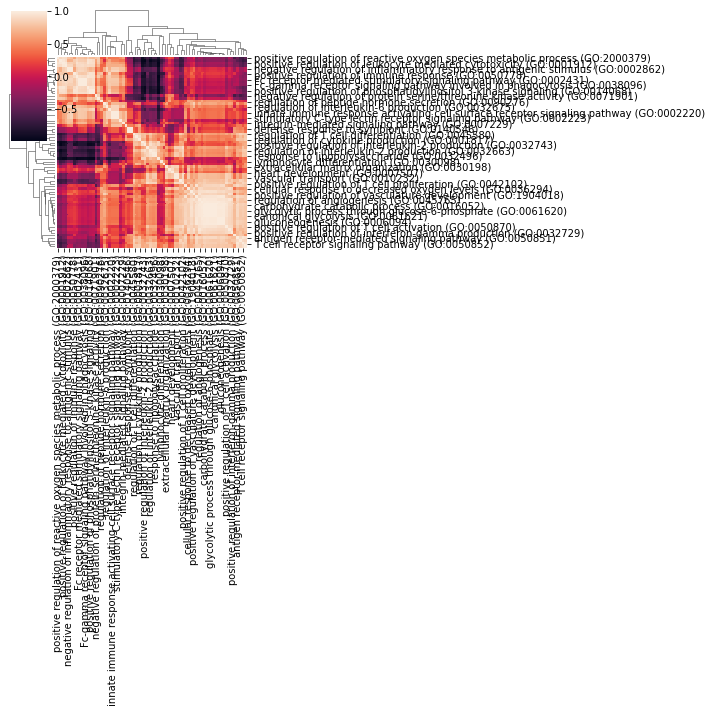

In [148]:
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(reduced_hits)].groupby(["NK/T Subclusters"]).mean().loc[cyto_clusts].corr())

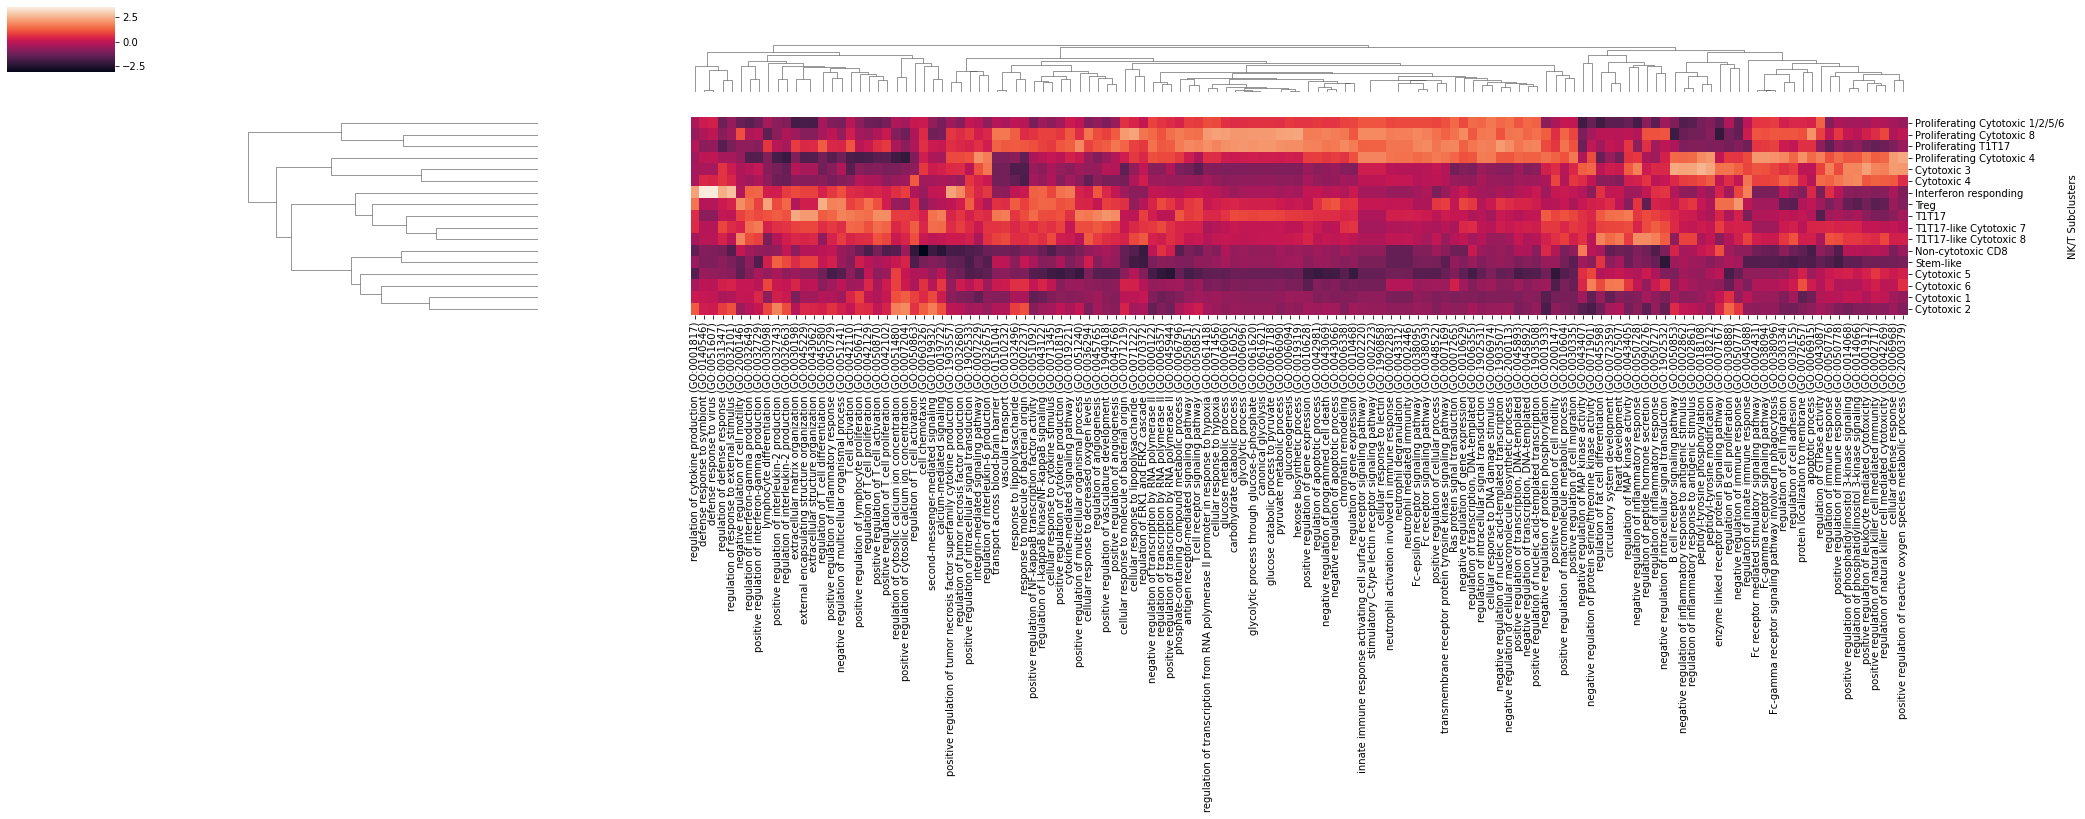

In [64]:
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters",]+list(combined_hits)].groupby(["NK/T Subclusters"]).mean(),figsize=(30,5),row_cluster=True,z_score=1,xticklabels=1)

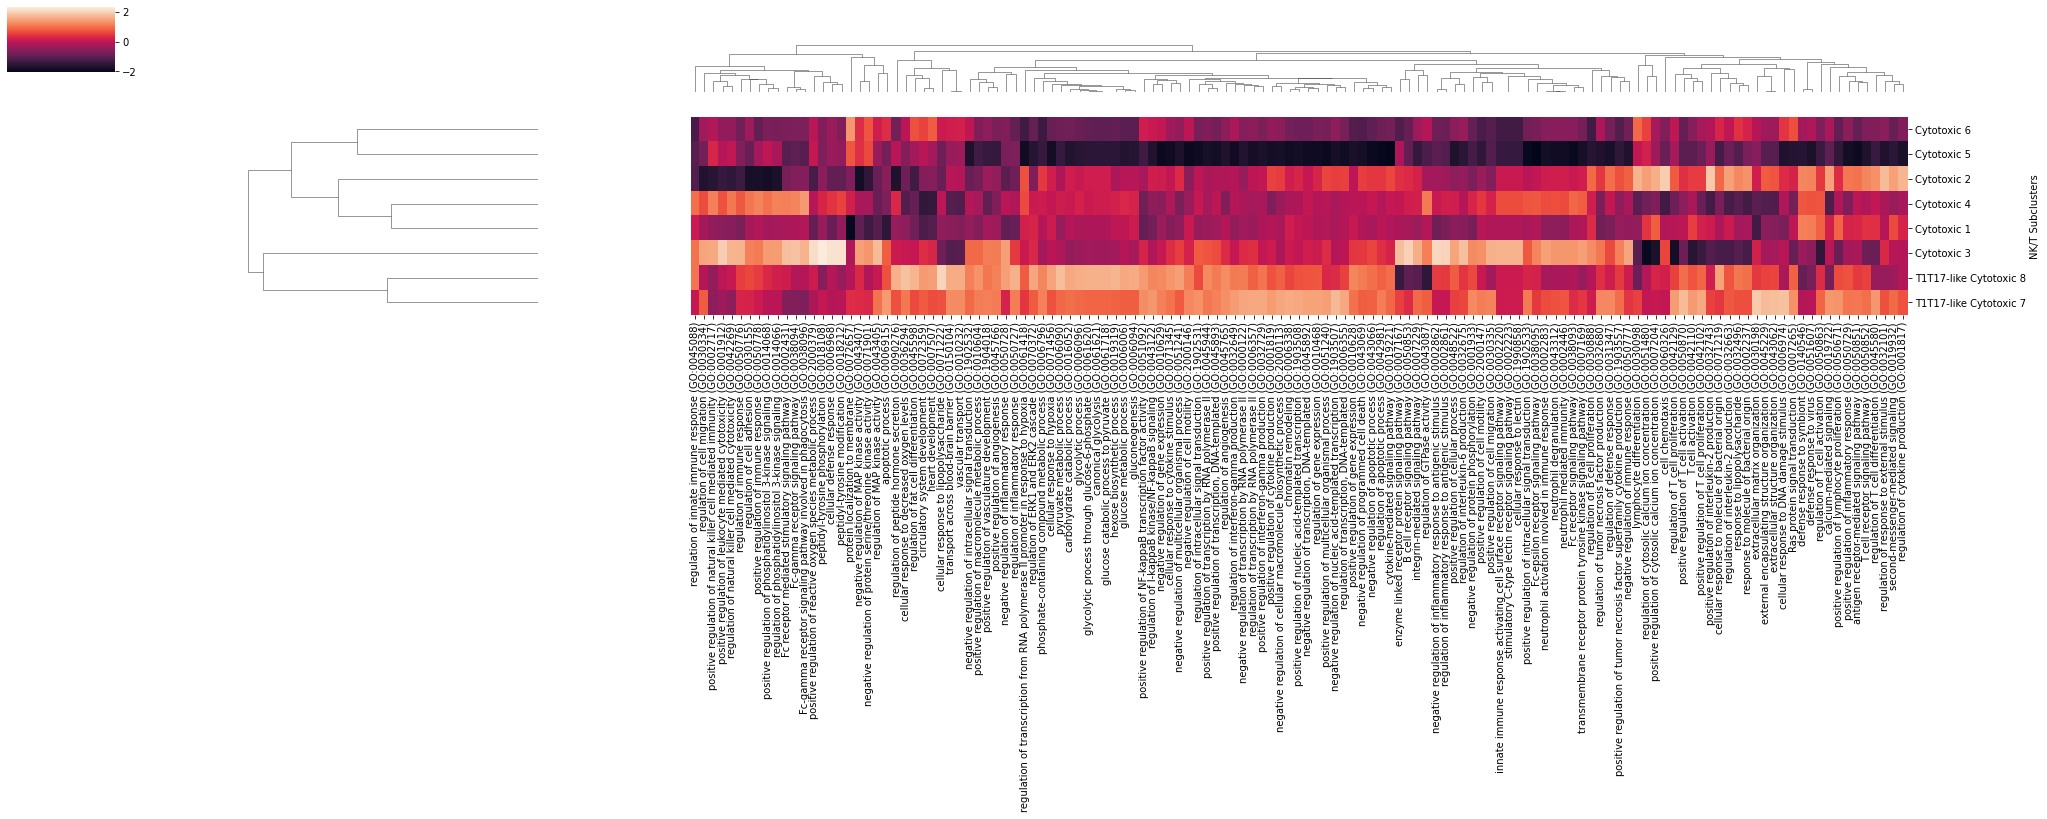

In [98]:
sns.clustermap(t_adata_nodub.obs[["NK/T Subclusters","sample"]+list(combined_hits)].groupby(["NK/T Subclusters","sample"]).mean().reset_index().groupby("NK/T Subclusters").mean().loc[cyto_clusts],figsize=(30,5),row_cluster=True,z_score=1,xticklabels=1)#.unstack()#.mean()

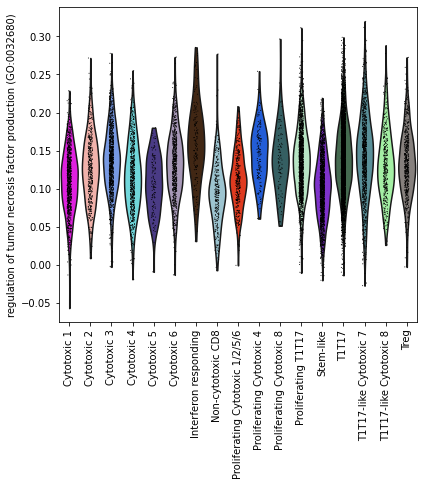

In [113]:
sc.pl.violin(t_adata_nodub, "regulation of tumor necrosis factor production (GO:0032680)",groupby="NK/T Subclusters", rotation=90)

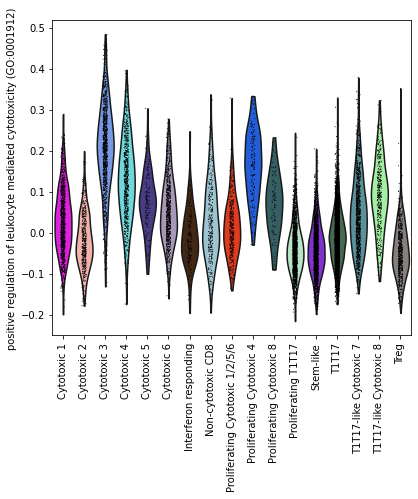

In [84]:
sc.pl.violin(t_adata_nodub, "positive regulation of leukocyte mediated cytotoxicity (GO:0001912)",groupby="NK/T Subclusters", rotation=90)

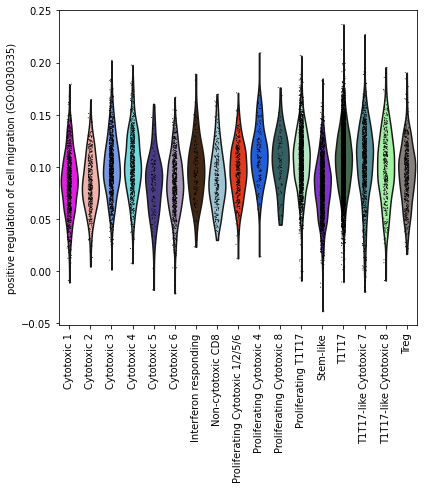

In [85]:

sc.pl.violin(t_adata_nodub, "positive regulation of cell migration (GO:0030335)",groupby="NK/T Subclusters", rotation=90)

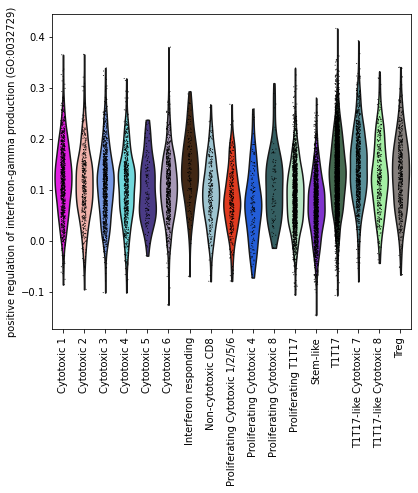

In [86]:



sc.pl.violin(t_adata_nodub, "positive regulation of interferon-gamma production (GO:0032729)",groupby="NK/T Subclusters", rotation=90)

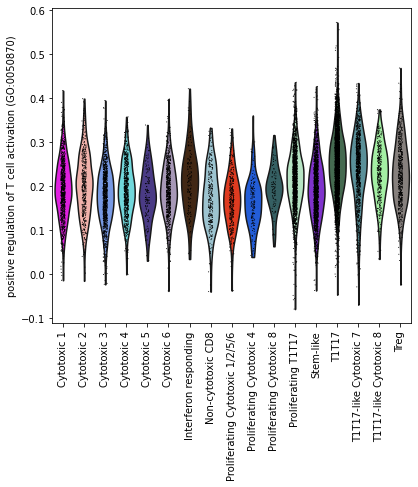

In [87]:



sc.pl.violin(t_adata_nodub, "positive regulation of T cell activation (GO:0050870)",groupby="NK/T Subclusters", rotation=90)

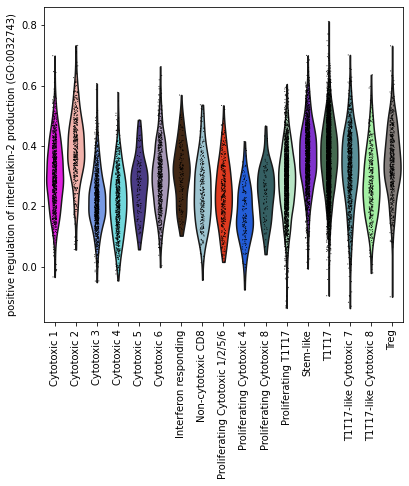

In [114]:

sc.pl.violin(t_adata_nodub, "positive regulation of interleukin-2 production (GO:0032743)",groupby="NK/T Subclusters", rotation=90)

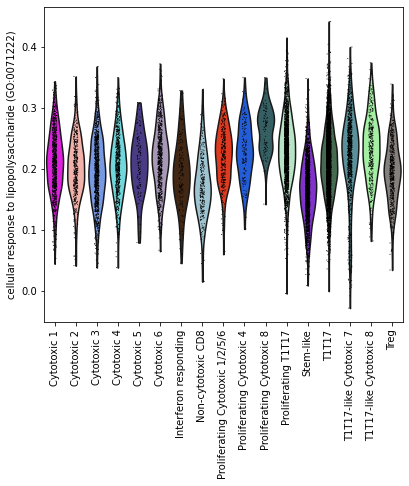

In [122]:

sc.pl.violin(t_adata_nodub, "cellular response to lipopolysaccharide (GO:0071222)",groupby="NK/T Subclusters", rotation=90)